<a href="https://colab.research.google.com/github/fsternini/anomaly-prediction/blob/development/anomaly_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Inputs and Imports

In [ ]:
!which python # should return /usr/local/bin/python
!python --version

/usr/local/bin/python
Python 3.10.12


In [ ]:
!git clone 'https://github.com/fsternini/anomaly-prediction.git'
%cd 'anomaly-prediction'
# Switch to the most updated branch
!git switch development
# Collect the most updated version of the repo
!git pull

Cloning into 'anomaly-prediction'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 20 (delta 7), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (20/20), 2.70 MiB | 12.62 MiB/s, done.
Resolving deltas: 100% (7/7), done.
/content/anomaly-prediction
Branch 'development' set up to track remote branch 'development' from 'origin'.
Switched to a new branch 'development'
Already up to date.


In [ ]:
!pip install -r requirements.txt -q

  Preparing metadata (setup.py) ... done


In [ ]:
from scipy.io import loadmat
from google.colab import drive
import colab_env
import os,sys
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score, f1_score, precision_recall_curve, auc
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.metrics import precision_recall_fscore_support
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.preprocessing import MinMaxScaler

drive.mount('/content/drive')

dataset_path = os.environ["ANOMALY_DATASET"]

Mounted at /content/gdrive
Mounted at /content/drive


##Data Loading

In [ ]:
file_name = 'C_Mod_for_nn.mat'

data = loadmat(os.path.join(dataset_path,file_name))
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Greenwald_fraction', 'Mirnov_norm_btor', 'Te_peaking_ECE', 'beta_p', 'ip_error_normalized', 'kappa', 'li', 'lower_gap', 'n_equal_1_normalized', 'q95', 'radiated_fraction', 'shot', 'time', 'time_until_disrupt', 'v_loop', 'z_error', 'signal_names'])


#EDA

##Dataframe creation

In [ ]:
print(data)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sun Oct  6 14:21:28 2019', '__version__': '1.0', '__globals__': [], 'Greenwald_fraction': array([[2.61671424e-01],
       [1.93636477e-01],
       [3.12397703e-21],
       ...,
       [1.67424858e-01],
       [1.69788092e-01],
       [1.66034207e-01]]), 'Mirnov_norm_btor': array([[1.2390554 ],
       [1.15398717],
       [3.54094219],
       ...,
       [0.16784951],
       [0.18845347],
       [0.1710373 ]]), 'Te_peaking_ECE': array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]]), 'beta_p': array([[ 0.14727603],
       [ 0.19911849],
       [-0.01403902],
       ...,
       [ 0.09726767],
       [ 0.10503101],
       [ 0.09966871]]), 'ip_error_normalized': array([[-0.1559327 ],
       [-0.21475341],
       [-0.66040082],
       ...,
       [-0.01495537],
       [-0.01148414],
       [-0.01281592]]), 'kappa': array([[1.57228386],
       [1.55385911],
       [1.69113302],
    

In [ ]:
columns = []
for d in data["signal_names"]:
  columns.append(d[0][0])
print(columns)

['Greenwald_fraction', 'Mirnov_norm_btor', 'Te_peaking_ECE', 'beta_p', 'ip_error_normalized', 'kappa', 'li', 'lower_gap', 'n_equal_1_normalized', 'q95', 'radiated_fraction', 'v_loop', 'z_error']


In [ ]:
data_filt = {key: value for key, value in data.items() if '__' not in key}
data_filt.pop("signal_names")
#print(data_filt)

array([[array(['Greenwald_fraction'], dtype='<U18')],
       [array(['Mirnov_norm_btor'], dtype='<U16')],
       [array(['Te_peaking_ECE'], dtype='<U14')],
       [array(['beta_p'], dtype='<U6')],
       [array(['ip_error_normalized'], dtype='<U19')],
       [array(['kappa'], dtype='<U5')],
       [array(['li'], dtype='<U2')],
       [array(['lower_gap'], dtype='<U9')],
       [array(['n_equal_1_normalized'], dtype='<U20')],
       [array(['q95'], dtype='<U3')],
       [array(['radiated_fraction'], dtype='<U17')],
       [array(['v_loop'], dtype='<U6')],
       [array(['z_error'], dtype='<U7')]], dtype=object)

In [ ]:
for key, value in data_filt.items():
  data_filt[key]= np.squeeze(value)

In [ ]:
df = pd.DataFrame(data_filt)
df.head()

,Greenwald_fraction,Mirnov_norm_btor,Te_peaking_ECE,beta_p,ip_error_normalized,kappa,li,lower_gap,n_equal_1_normalized,q95,radiated_fraction,shot,time,time_until_disrupt,v_loop,z_error
0,2.616714e-01,1.239055,NaN,0.147276,-0.155933,1.572284,1.440702,0.071738,0.000885,5.205303,0.408387,1150915029,0.2850,0.0141,4.186112,-0.004279
1,1.936365e-01,1.153987,NaN,0.199118,-0.214753,1.553859,1.470170,0.077982,0.001154,5.151639,1.701884,1150915029,0.2900,0.0091,3.770813,0.000107
2,3.123977e-21,3.540942,NaN,-0.014039,-0.660401,1.691133,1.032967,0.088654,0.003092,5.954643,0.276097,1150915029,0.2950,0.0041,7.111877,0.004702
3,1.853891e-01,0.208537,NaN,0.001086,-0.264637,1.331522,1.553290,0.094562,0.001163,4.707932,0.665236,1120131006,0.1895,0.0150,-2.671509,-0.007156
4,1.804675e-01,0.194072,NaN,0.024498,-0.246736,1.388904,1.564471,0.106611,0.001136,4.985343,0.510057,1120131006,0.1945,0.0100,-2.581421,-0.018531


In [ ]:
df.set_index(["shot","time"],inplace=True)

In [ ]:
df.head()

Greenwald_fraction  Mirnov_norm_btor  Te_peaking_ECE  \
shot       time                                                           
1150915029 0.2850        2.616714e-01          1.239055             NaN   
           0.2900        1.936365e-01          1.153987             NaN   
           0.2950        3.123977e-21          3.540942             NaN   
1120131006 0.1895        1.853891e-01          0.208537             NaN   
           0.1945        1.804675e-01          0.194072             NaN   

                     beta_p  ip_error_normalized     kappa        li  \
shot       time                                                        
1150915029 0.2850  0.147276            -0.155933  1.572284  1.440702   
           0.2900  0.199118            -0.214753  1.553859  1.470170   
           0.2950 -0.014039            -0.660401  1.691133  1.032967   
1120131006 0.1895  0.001086            -0.264637  1.331522  1.553290   
           0.1945  0.024498            -0.246736  1.388904  1.564471   

                   lower_gap  n_equal_1_normalized       q95  \
shot       time                                                
1150915029 0.2850   0.071738              0.000885  5.205303   
           0.2900   0.077982              0.001154  5.151639   
           0.2950   0.088654              0.003092  5.954643   
1120131006 0.1895   0.094562              0.001163  4.707932   
           0.1945   0.106611              0.001136  4.985343   

                   radiated_fraction  time_until_disrupt    v_loop   z_error  
shot       time                                                               
1150915029 0.2850           0.408387              0.0141  4.186112 -0.004279  
           0.2900           1.701884              0.0091  3.770813  0.000107  
           0.2950           0.276097              0.0041  7.111877  0.004702  
1120131006 0.1895           0.665236              0.0150 -2.671509 -0.007156  
           0.1945           0.510057              0.0100 -2.581421 -0.018531

##Numerosity Analysis

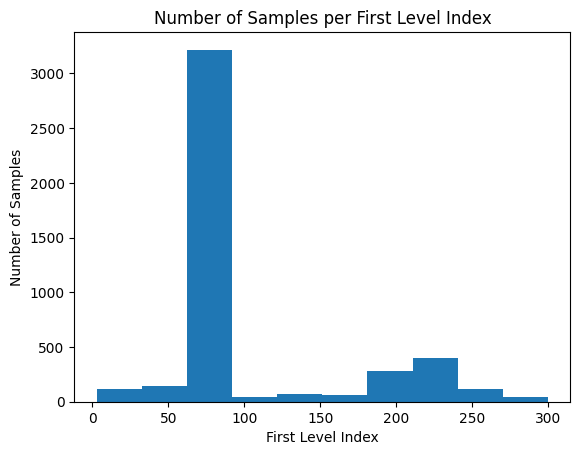

In [ ]:
sample_counts = df.groupby(level=0).size()
sample_counts.plot(kind='hist')
plt.xlabel('First Level Index')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per First Level Index')
plt.show()

In [ ]:
df.count()

Greenwald_fraction      479237
Mirnov_norm_btor        479620
Te_peaking_ECE          338012
beta_p                  479692
ip_error_normalized     479692
kappa                   479691
li                      479692
lower_gap               479692
n_equal_1_normalized    479692
q95                     479689
radiated_fraction       479160
time_until_disrupt       78829
v_loop                  479692
z_error                 479692
dtype: int64

##Label Creation

In [ ]:
df[df['time_until_disrupt']<0.03].count()

Greenwald_fraction      5941
Mirnov_norm_btor        5959
Te_peaking_ECE          1925
beta_p                  5959
ip_error_normalized     5959
kappa                   5958
li                      5959
lower_gap               5959
n_equal_1_normalized    5959
q95                     5956
radiated_fraction       5959
time_until_disrupt      5959
v_loop                  5959
z_error                 5959
dtype: int64

In [ ]:
df["disrupt_30ms"]=False

In [ ]:
df.loc[df['time_until_disrupt']<0.03, "disrupt_30ms"]=True

In [ ]:
df.head()

Greenwald_fraction  Mirnov_norm_btor  Te_peaking_ECE  \
shot       time                                                           
1150915029 0.2850        2.616714e-01          1.239055             NaN   
           0.2900        1.936365e-01          1.153987             NaN   
           0.2950        3.123977e-21          3.540942             NaN   
1120131006 0.1895        1.853891e-01          0.208537             NaN   
           0.1945        1.804675e-01          0.194072             NaN   

                     beta_p  ip_error_normalized     kappa        li  \
shot       time                                                        
1150915029 0.2850  0.147276            -0.155933  1.572284  1.440702   
           0.2900  0.199118            -0.214753  1.553859  1.470170   
           0.2950 -0.014039            -0.660401  1.691133  1.032967   
1120131006 0.1895  0.001086            -0.264637  1.331522  1.553290   
           0.1945  0.024498            -0.246736  1.388904  1.564471   

                   lower_gap  n_equal_1_normalized       q95  \
shot       time                                                
1150915029 0.2850   0.071738              0.000885  5.205303   
           0.2900   0.077982              0.001154  5.151639   
           0.2950   0.088654              0.003092  5.954643   
1120131006 0.1895   0.094562              0.001163  4.707932   
           0.1945   0.106611              0.001136  4.985343   

                   radiated_fraction  time_until_disrupt    v_loop   z_error  \
shot       time                                                                
1150915029 0.2850           0.408387              0.0141  4.186112 -0.004279   
           0.2900           1.701884              0.0091  3.770813  0.000107   
           0.2950           0.276097              0.0041  7.111877  0.004702   
1120131006 0.1895           0.665236              0.0150 -2.671509 -0.007156   
           0.1945           0.510057              0.0100 -2.581421 -0.018531   

                   disrupt_30ms  
shot       time                  
1150915029 0.2850          True  
           0.2900          True  
           0.2950          True  
1120131006 0.1895          True  
           0.1945          True

In [ ]:
df.count()

Greenwald_fraction      479237
Mirnov_norm_btor        479620
Te_peaking_ECE          338012
beta_p                  479692
ip_error_normalized     479692
kappa                   479691
li                      479692
lower_gap               479692
n_equal_1_normalized    479692
q95                     479689
radiated_fraction       479160
time_until_disrupt       78829
v_loop                  479692
z_error                 479692
disrupt_30ms            479692
dtype: int64

##NaN Management

In [ ]:
df.isna().sum()

Greenwald_fraction         455
Mirnov_norm_btor            72
Te_peaking_ECE          141680
beta_p                       0
ip_error_normalized          0
kappa                        1
li                           0
lower_gap                    0
n_equal_1_normalized         0
q95                          3
radiated_fraction          532
time_until_disrupt      400863
v_loop                       0
z_error                      0
disrupt_30ms                 0
dtype: int64

In [ ]:
df.drop(columns=["time_until_disrupt","Te_peaking_ECE"],inplace=True)

In [ ]:
df.isna().sum()

Greenwald_fraction      455
Mirnov_norm_btor         72
beta_p                    0
ip_error_normalized       0
kappa                     1
li                        0
lower_gap                 0
n_equal_1_normalized      0
q95                       3
radiated_fraction       532
v_loop                    0
z_error                   0
disrupt_30ms              0
dtype: int64

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.count()

Greenwald_fraction      478630
Mirnov_norm_btor        478630
beta_p                  478630
ip_error_normalized     478630
kappa                   478630
li                      478630
lower_gap               478630
n_equal_1_normalized    478630
q95                     478630
radiated_fraction       478630
v_loop                  478630
z_error                 478630
disrupt_30ms            478630
dtype: int64

##Data representation

In [ ]:
df["disrupt_30ms"].value_counts()

disrupt_30ms
False    472692
True       5938
Name: count, dtype: int64

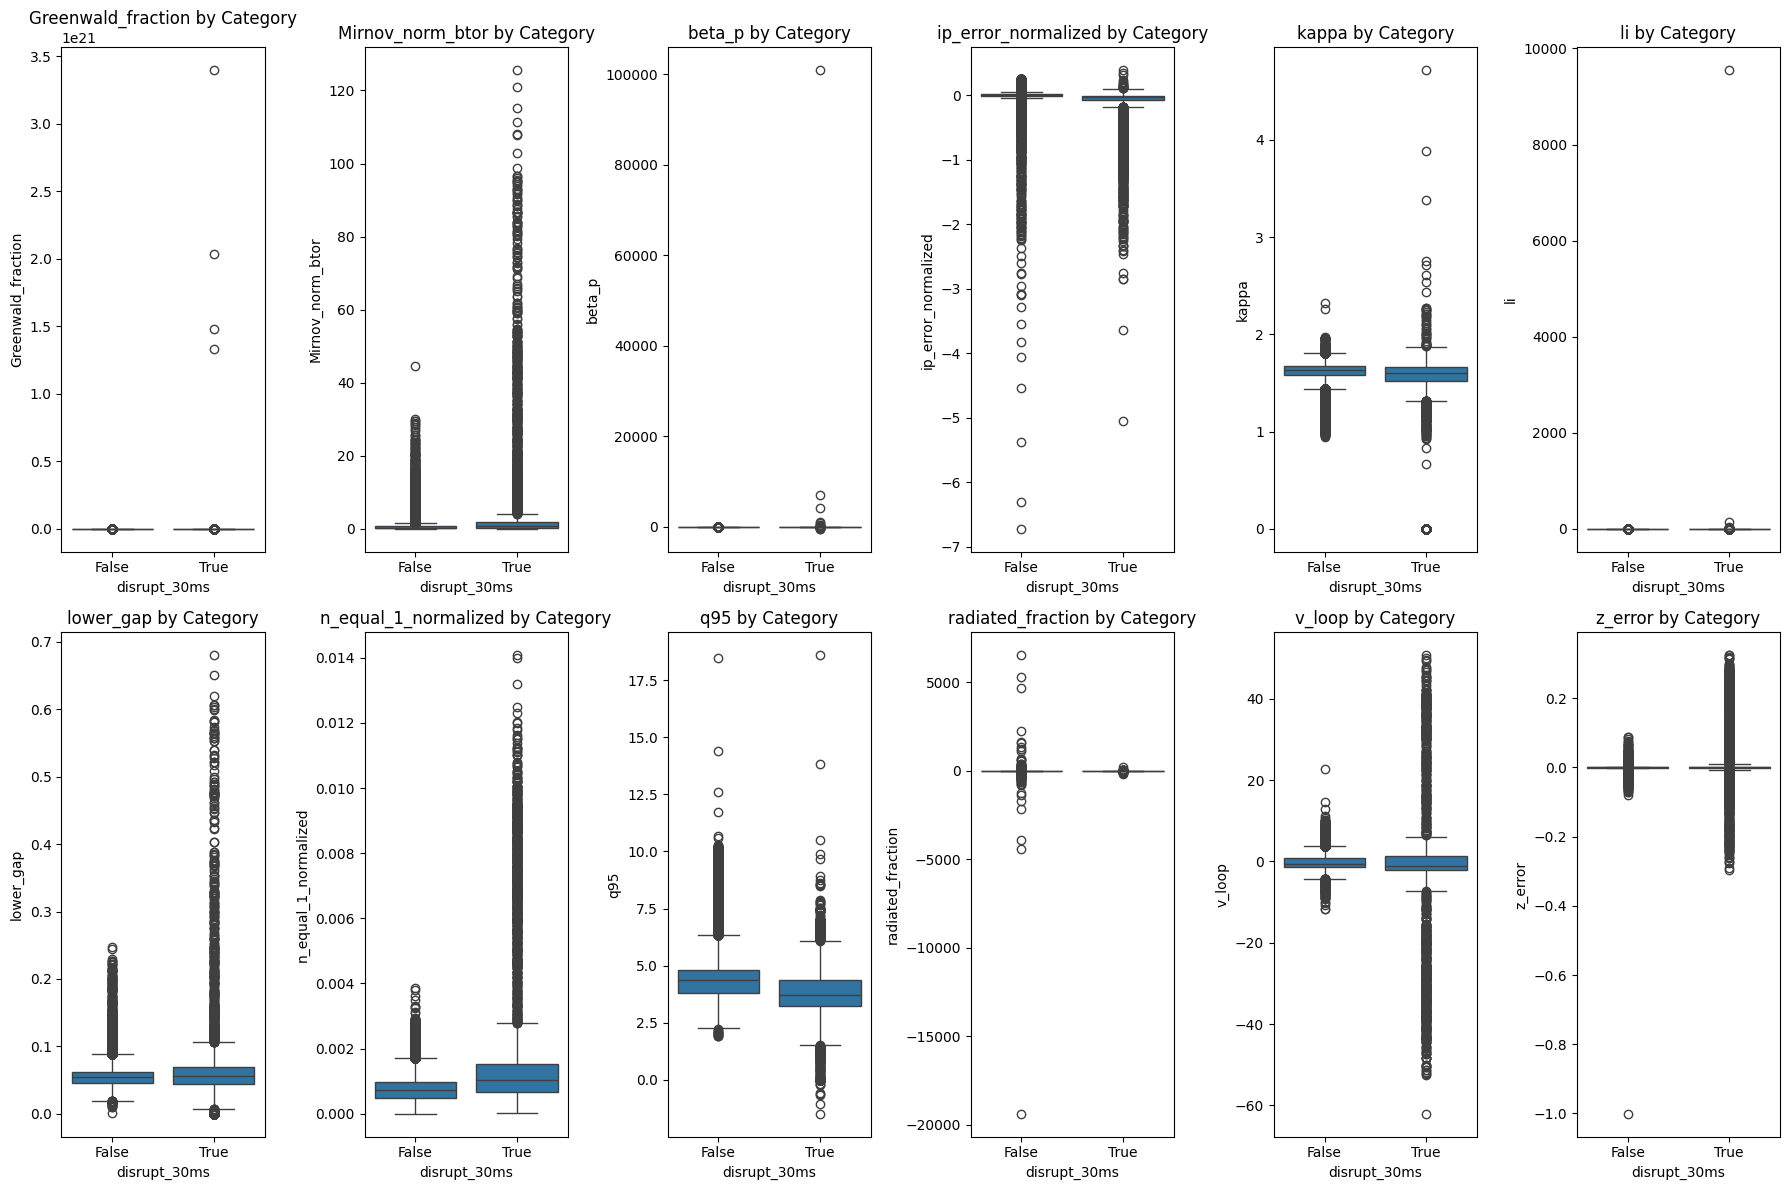

In [ ]:
plt.figure(figsize=(18, 12))

for index, feature in enumerate(df.select_dtypes(include=[np.number]).columns, 1):
    plt.subplot(2, int(len(df.select_dtypes(include=[np.number]).columns)/2), index)
    sns.boxplot(x='disrupt_30ms', y=feature, data=df)
    plt.title(f'{feature} by Category')

plt.tight_layout()
plt.show()

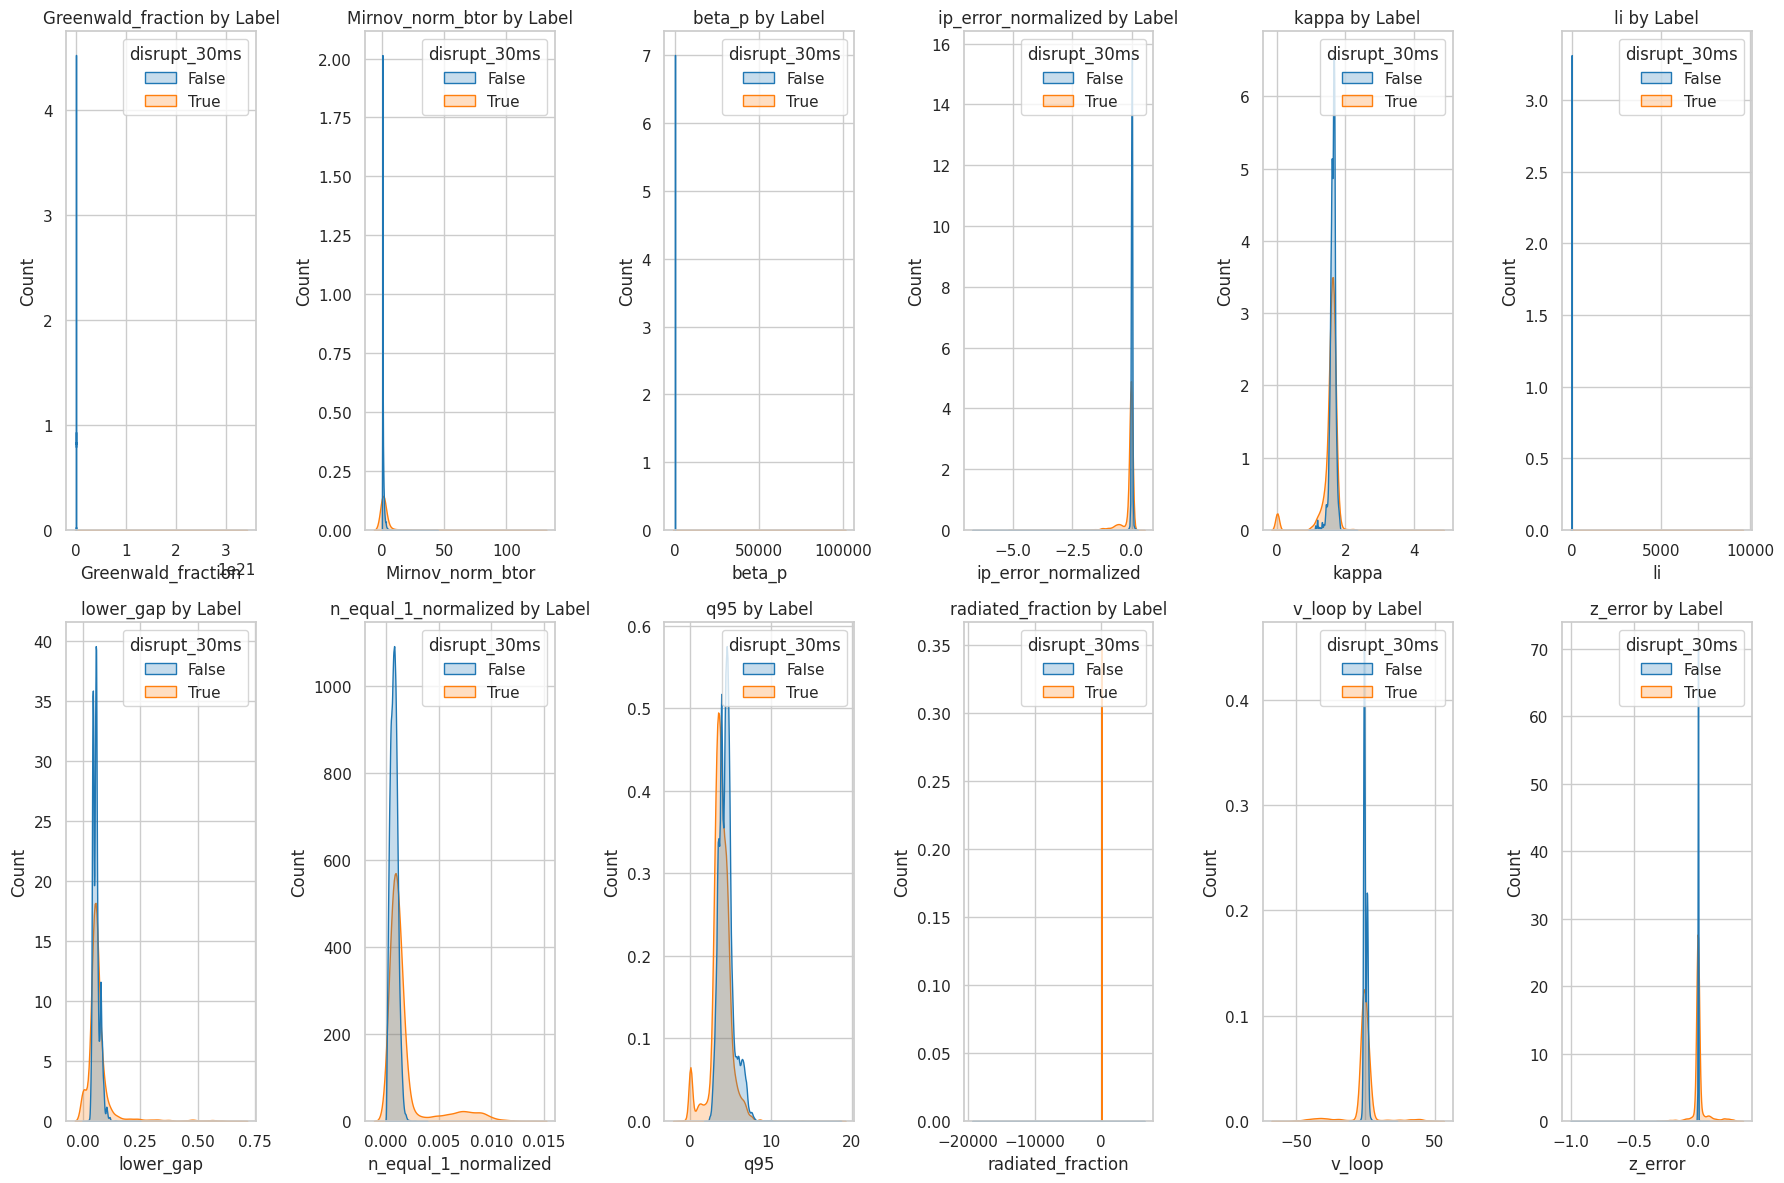

In [ ]:
sns.set(style='whitegrid')
plt.figure(figsize=(18, 12))

numeric_columns = df.select_dtypes(include='number').columns
num_plots = len(numeric_columns)

for index, col in enumerate(numeric_columns, start=1):
    plt.subplot(2, int(num_plots/2), index)
    sns.kdeplot(data=df, x=col, hue='disrupt_30ms', fill=True, common_norm=False, palette='tab10')
    plt.title(f'{col} by Label')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.grid(True)

plt.tight_layout()
plt.show()

##Train Test Split

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['disrupt_30ms'], random_state=42)

In [ ]:
X_train = np.array(train_df.drop(columns=["disrupt_30ms"]))
y_train = np.array(train_df["disrupt_30ms"])
X_test = np.array(test_df.drop(columns=["disrupt_30ms"]))
y_test = np.array(test_df["disrupt_30ms"])
print(X_train, y_train)

[[ 2.65229911e-01  1.13349831e+00  5.72879255e-01 ...  2.88943172e-01
  -9.53796387e-01 -3.83627281e-04]
 [ 2.69912332e-01  4.98025894e-01  3.64975333e-01 ...  1.84047997e-01
   6.34981275e-01  1.20978853e-04]
 [ 1.96628153e-01  9.11588430e-01  4.24721807e-01 ...  1.11010563e+00
   1.14135742e-01 -2.96041166e-04]
 ...
 [ 4.71657485e-01  4.10500541e-02  4.65717167e-01 ...  4.80820179e-01
  -8.43573391e-01 -2.24022823e-03]
 [ 5.44782221e-01  7.98882484e-01  3.32017183e-01 ...  7.07769513e-01
  -1.36608887e+00  9.83926235e-04]
 [ 1.60234004e-01  2.03665543e+00  3.26759398e-01 ...  6.23595491e-02
   2.20718145e+00 -3.36552825e-04]] [False False False ... False False False]


##Train Data Visualization

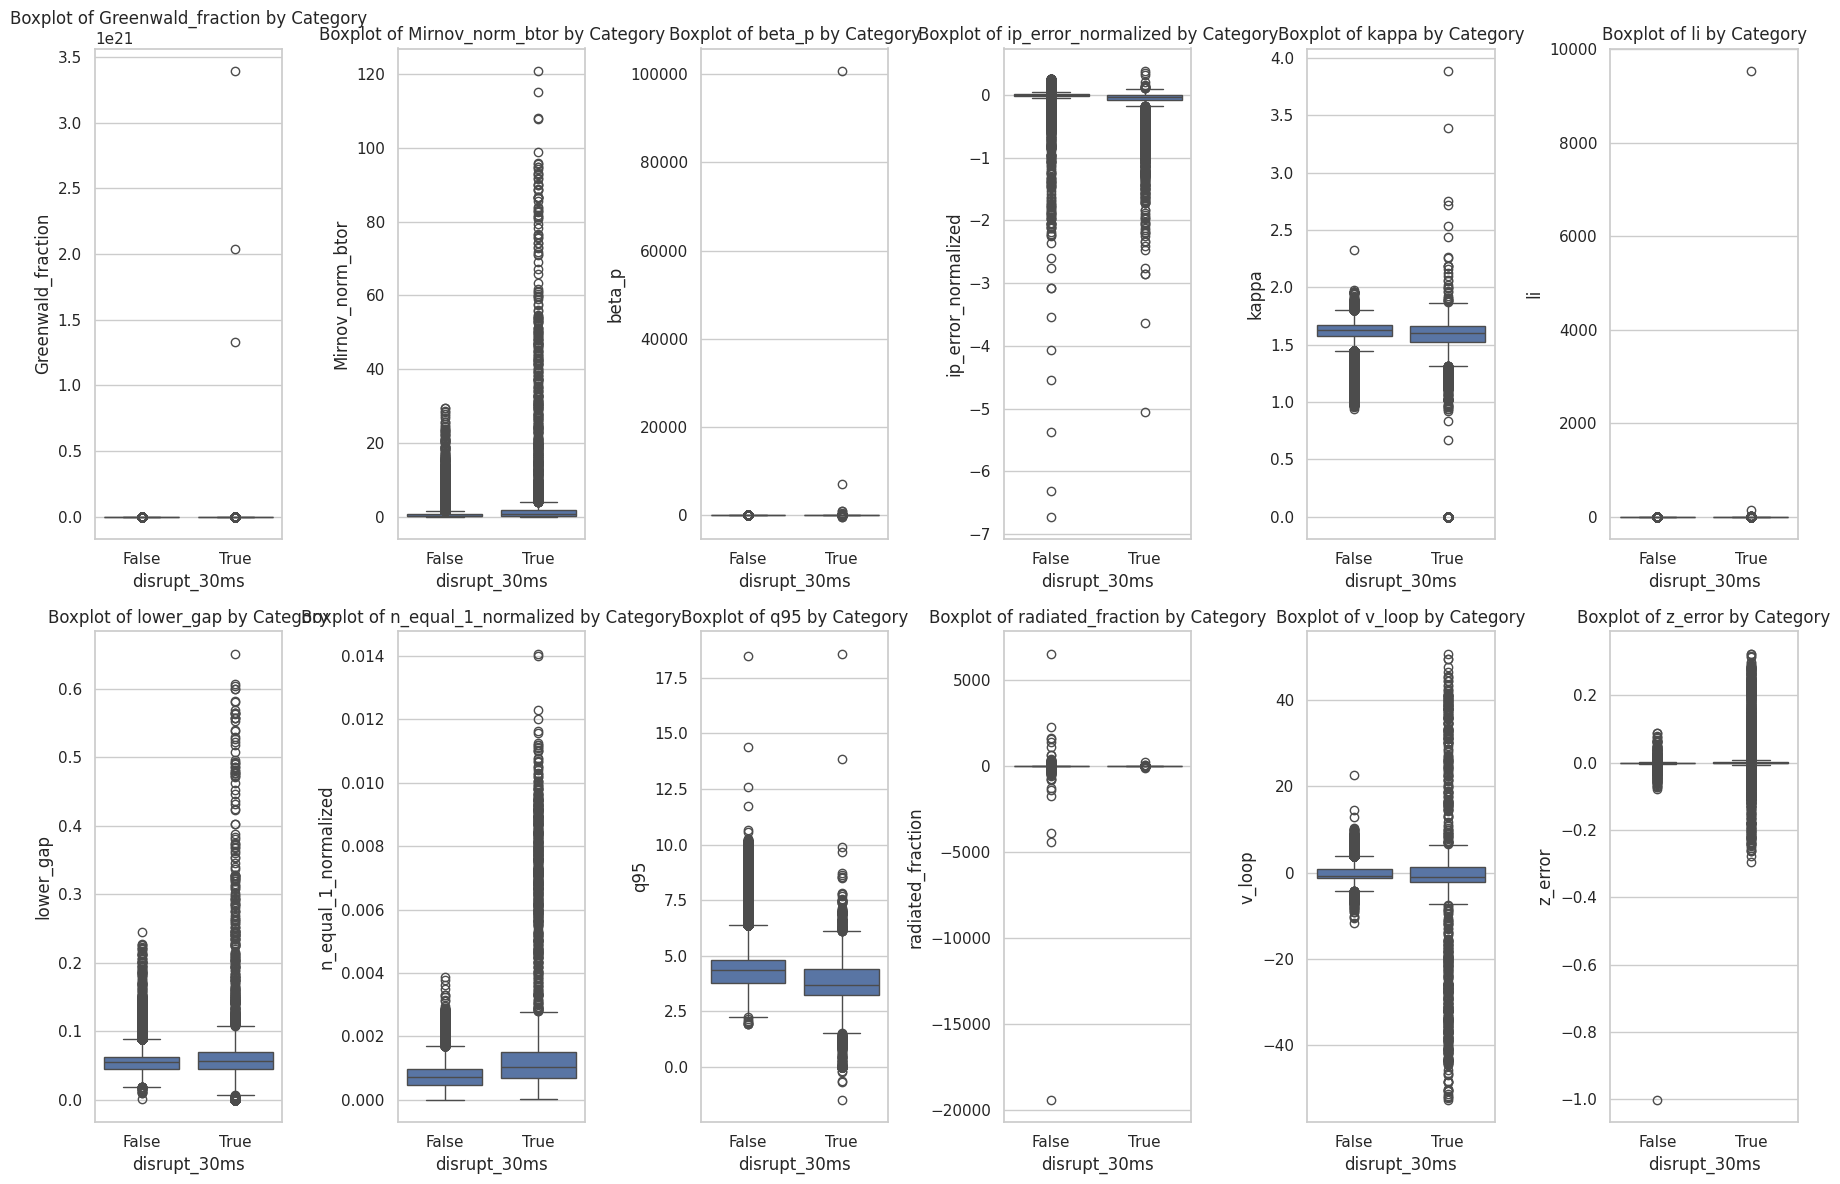

In [ ]:
plt.figure(figsize=(18, 12))

for index, feature in enumerate(train_df.select_dtypes(include=[np.number]).columns, 1):
    plt.subplot(2, int(len(train_df.select_dtypes(include=[np.number]).columns)/2), index)
    sns.boxplot(x='disrupt_30ms', y=feature, data=train_df)
    plt.title(f'Boxplot of {feature} by Category')

plt.tight_layout()
plt.show()

###PCA

In [ ]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_train)

In [ ]:
explained_variance = pca.explained_variance_ratio_
print("\nExplained Variance Ratio:", explained_variance)


Explained Variance Ratio: [1.00000000e+00 5.90762925e-34]


In [ ]:
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])
pca_df.head()

,Principal Component 1,Principal Component 2
0,-2.018423e+16,0.037945
1,-2.018423e+16,-0.197858
2,-2.018423e+16,-0.143824
3,-2.018423e+16,-0.233500
4,-2.018423e+16,-0.202396


In [ ]:
pca_df["disrupt_30ms"] = train_df["disrupt_30ms"].reset_index(drop=True)
pca_df["disrupt_30ms"].unique()

array([False,  True])

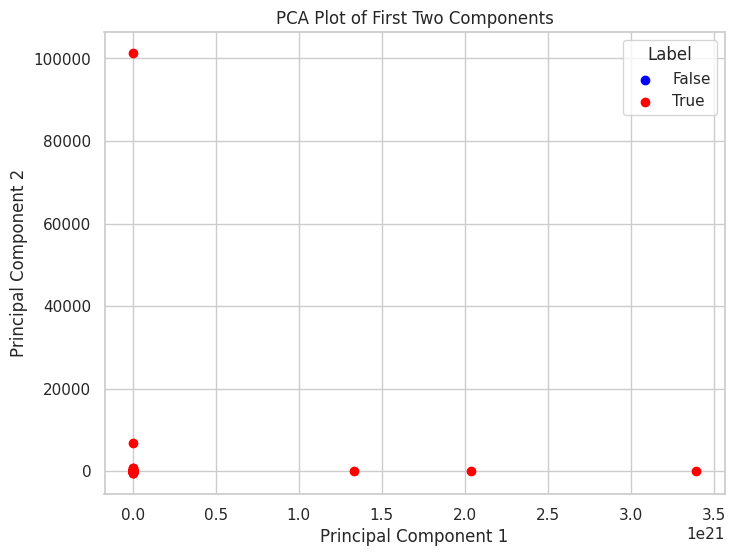

In [ ]:
plt.figure(figsize=(8, 6))
colors = {False: 'blue', True: 'red'}
for label in pca_df["disrupt_30ms"].unique():
    subset = pca_df[pca_df["disrupt_30ms"] == label]
    plt.scatter(subset['Principal Component 1'], subset['Principal Component 2'], c=colors[label], label=label)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Label')
plt.title('PCA Plot of First Two Components')
plt.grid(True)
plt.show()

#Anomaly detection

##Isolation Forest

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_train)

In [ ]:
isolation_forest = IsolationForest(max_samples=100, random_state=42)
isolation_forest.fit(scaled_data)

IsolationForest(max_samples=100, random_state=42)

In [ ]:
y_pred = isolation_forest.predict(scaled_data)
print(y_pred)
print(np.unique(y_pred,return_counts=True))

[ 1  1  1 ...  1 -1  1]
(array([-1,  1]), array([ 22825, 312216]))


In [ ]:
y_train_isfor=y_train.astype(int)*(-2)+1
print(y_train_isfor)
print(np.unique(y_train_isfor,return_counts=True))

[1 1 1 ... 1 1 1]
(array([-1,  1]), array([  4157, 330884]))


In [ ]:
cm = confusion_matrix(y_train_isfor, y_pred, labels=[1, -1])

precision = precision_score(y_train_isfor, y_pred, pos_label=-1)
recall = recall_score(y_train_isfor, y_pred, pos_label=-1)

print("Confusion Matrix:")
print(cm)
print(f"\nPrecision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

print("\nClassification Report:")
print(classification_report(y_train, y_pred, labels=[1, -1], target_names=['Normal', 'Anomalous']))

Confusion Matrix:
[[309947  20937]
 [  2269   1888]]

Precision: 0.08
Recall: 0.45

Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      Normal       0.01      0.55      0.01      4157
   Anomalous       0.00      0.00      0.00         0

   micro avg       0.01      0.55      0.01      4157
   macro avg       0.00      0.27      0.01      4157
weighted avg       0.01      0.55      0.01      4157



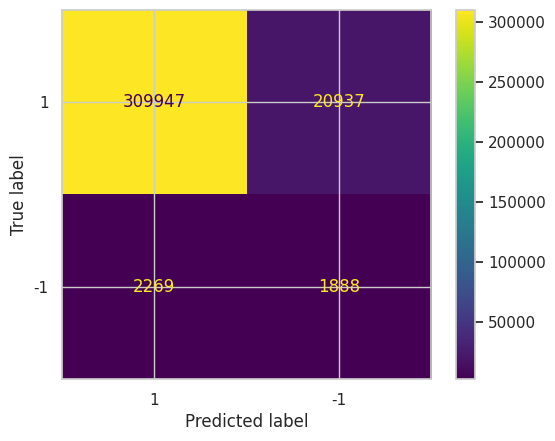

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,-1])
disp.plot()
plt.show()

#Classification

The approach used here is to first focus on techniques with lower computational and complexity requirements, and only after, if performance are not deemed adequate, proceed to increase complexity and computational power requirements.

##Linear SVM

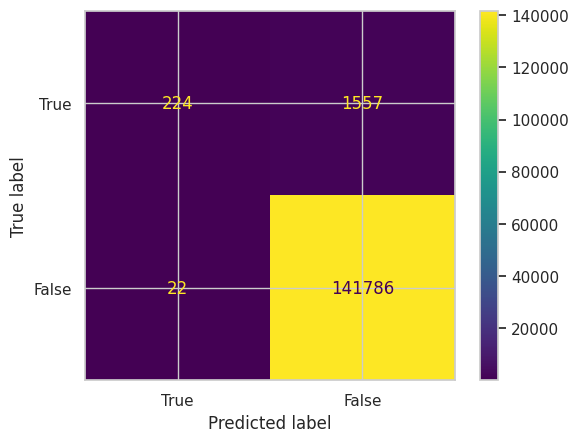

              precision    recall  f1-score   support

        True       0.91      0.13      0.22      1781
       False       0.99      1.00      0.99    141808

    accuracy                           0.99    143589
   macro avg       0.95      0.56      0.61    143589
weighted avg       0.99      0.99      0.98    143589



In [ ]:
clf = make_pipeline(StandardScaler(), LinearSVC(dual=False,
                                                random_state=0, tol=1e-5))
labels = [True,False]
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
precision, recall, fscore, support = precision_recall_fscore_support(y_test,y_pred, labels=labels)
cm=confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred, labels=labels))

##SVM

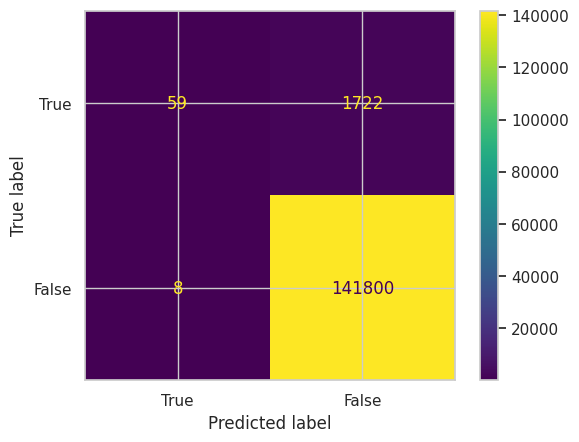

              precision    recall  f1-score   support

        True       0.88      0.03      0.06      1781
       False       0.99      1.00      0.99    141808

    accuracy                           0.99    143589
   macro avg       0.93      0.52      0.53    143589
weighted avg       0.99      0.99      0.98    143589



In [ ]:
rescaler = StandardScaler()
clf = make_pipeline(StandardScaler(), Nystroem(gamma=.2, random_state=0, n_components=300), LinearSVC(dual=False, random_state=0))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
precision, recall, fscore, support = precision_recall_fscore_support(y_test,y_pred, labels=labels)
cm=confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred, labels=labels))

##Resampling for performance improvements (SMOTE)

Resampling is tried, to mitigate the imbalance of the dataset

In [ ]:
resampler = SMOTE(sampling_strategy="not majority", random_state=42)

###Linear SVM

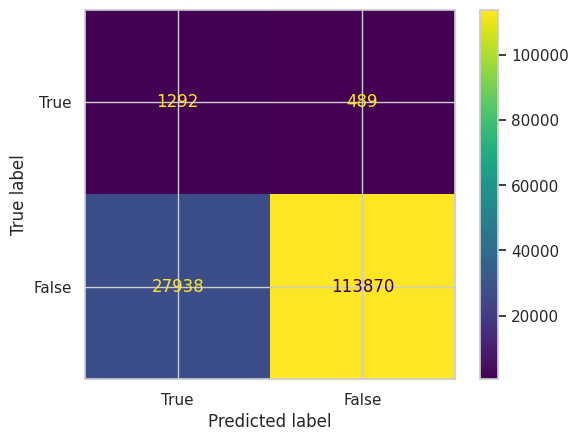

              precision    recall  f1-score   support

        True       0.04      0.73      0.08      1781
       False       1.00      0.80      0.89    141808

    accuracy                           0.80    143589
   macro avg       0.52      0.76      0.49    143589
weighted avg       0.98      0.80      0.88    143589



In [ ]:
clf = make_pipeline(StandardScaler(), LinearSVC(dual=False,
                                                random_state=0, tol=1e-5))
labels = [True,False]
x_res, y_res = resampler.fit_resample(X_train,y_train)
clf.fit(x_res, y_res)
y_pred = clf.predict(X_test)
precision, recall, fscore, support = precision_recall_fscore_support(y_test,y_pred, labels=labels)
cm=confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred, labels=labels))

###SVM

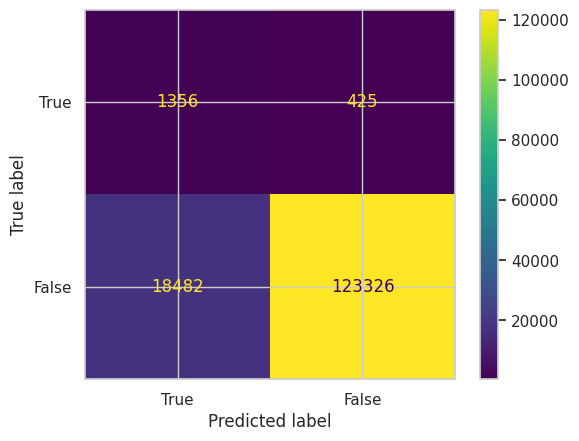

              precision    recall  f1-score   support

        True       0.07      0.76      0.13      1781
       False       1.00      0.87      0.93    141808

    accuracy                           0.87    143589
   macro avg       0.53      0.82      0.53    143589
weighted avg       0.99      0.87      0.92    143589



In [ ]:
clf = make_pipeline(StandardScaler(), Nystroem(gamma=.2, random_state=0, n_components=300), LinearSVC(dual=False, random_state=0))
x_res, y_res = resampler.fit_resample(X_train,y_train)
clf.fit(x_res, y_res)
y_pred = clf.predict(X_test)
precision, recall, fscore, support = precision_recall_fscore_support(y_test,y_pred, labels=labels)
cm=confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred, labels=labels))

##XGBoost

XGBoost is the algorithm selected. Therefore, after the first iteration, additional improvements are tried in the XGBoost optimization.

###First Iteration

[0]	validation_0-logloss:0.12116
[1]	validation_0-logloss:0.09749
[2]	validation_0-logloss:0.08085
[3]	validation_0-logloss:0.06891
[4]	validation_0-logloss:0.06056
[5]	validation_0-logloss:0.05442
[6]	validation_0-logloss:0.04977
[7]	validation_0-logloss:0.04614
[8]	validation_0-logloss:0.04371
[9]	validation_0-logloss:0.04196
[10]	validation_0-logloss:0.04052
[11]	validation_0-logloss:0.03930
[12]	validation_0-logloss:0.03849
[13]	validation_0-logloss:0.03770
[14]	validation_0-logloss:0.03718
[15]	validation_0-logloss:0.03683
[16]	validation_0-logloss:0.03653
[17]	validation_0-logloss:0.03623
[18]	validation_0-logloss:0.03592
[19]	validation_0-logloss:0.03567
[20]	validation_0-logloss:0.03544
[21]	validation_0-logloss:0.03501
[22]	validation_0-logloss:0.03470
[23]	validation_0-logloss:0.03453
[24]	validation_0-logloss:0.03444
[25]	validation_0-logloss:0.03423
[26]	validation_0-logloss:0.03406
[27]	validation_0-logloss:0.03393
[28]	validation_0-logloss:0.03379
[29]	validation_0-loglos

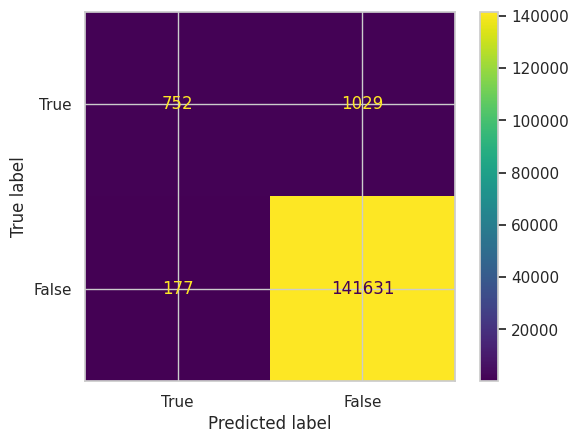

              precision    recall  f1-score   support

        True       0.81      0.42      0.55      1781
       False       0.99      1.00      1.00    141808

    accuracy                           0.99    143589
   macro avg       0.90      0.71      0.78    143589
weighted avg       0.99      0.99      0.99    143589



In [ ]:
model = xgb.XGBClassifier(early_stopping_rounds=2)
clf_xgb = make_pipeline(model)
x_train_xgb, x_eval_xgb, y_train_xgb, y_eval_xgb = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
clf_xgb.fit(x_train_xgb, y_train_xgb, xgbclassifier__eval_set=[(x_eval_xgb, y_eval_xgb)])
y_pred = clf_xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred, labels=labels))

###Second Iteration and further optimization

In [ ]:
cv_params = {'max_depth': [1,2,3,4,5,6], 'min_child_weight': [1,2,3,4]}    # parameters to be tried in the grid search
fix_params = {'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic'}   #other parameters, fixed for the moment
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 5)

In [ ]:
csv.fit(X_train, y_train)


AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [ ]:
csv.cv_results_

{'mean_fit_time': array([2.75134277, 1.98559966, 2.16361384, 1.49512186, 2.19485111,
        2.33013363, 2.18138285, 2.16091866, 2.90809832, 2.39844007,
        1.8756916 , 2.39865594, 2.7319416 , 2.8102531 , 2.83229094,
        2.57177   , 3.489329  , 2.88734469, 2.97554908, 4.69754529,
        3.90025525, 4.96426368, 3.46074786, 3.42635617]),
 'std_fit_time': array([1.66594784, 0.61307333, 0.99631958, 0.02961422, 0.944217  ,
        1.01782824, 1.01934229, 0.98515662, 1.68261736, 1.05970387,
        0.01640636, 1.0571903 , 1.05588538, 1.37138641, 1.08379875,
        0.93931929, 1.36041265, 0.64132547, 1.15226688, 3.36399895,
        1.21019945, 3.08303257, 1.18724213, 1.13057452]),
 'mean_score_time': array([0.07522821, 0.07015171, 0.05807557, 0.0634201 , 0.06860094,
        0.0670454 , 0.07517266, 0.07946506, 0.10009732, 0.0939661 ,
        0.08683095, 0.08355618, 0.11838341, 0.10244255, 0.12270875,
        0.10712328, 0.13296494, 0.14548378, 0.13130016, 0.22891293,
        0.182252

In [ ]:
csv.best_params_

{'max_depth': 6, 'min_child_weight': 1}

In [ ]:
cv_params = {'subsample': [0.8,0.9,1], 'max_delta_step': [0,1,2,4,8]}
fix_params = {'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 6, 'min_child_weight':1}
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 5)
csv.fit(X_train, y_train)
csv.best_params_

{'max_delta_step': 4, 'subsample': 0.9}

In [ ]:
cv_params = {'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]}
fix_params['max_delta_step'] = 4
fix_params['subsample'] = 0.9
csv = GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 5)
csv.fit(X_train, y_train)
#csv.grid_scores_

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.2, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None, max_delta_step=4,
                                     max_depth=6, max_leaves=None,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints=None,
                                     multi_strategy=None, n_estimators=100,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3,
                                           0.35]},
             scoring='f1')

In [ ]:
csv.best_params_

{'learning_rate': 0.3}

In [ ]:
fix_params['learning_rate'] = 0.3
params_final =  fix_params
print(params_final)

{'learning_rate': 0.3, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 6, 'min_child_weight': 1, 'max_delta_step': 4, 'subsample': 0.9}


In [ ]:
xgdmat_train = xgb.DMatrix(X_train, y_train)
xgdmat_test = xgb.DMatrix(X_test, y_test)
xgb_final = xgb.train(params_final, xgdmat_train, num_boost_round = 100)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:03:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


ROC AUC: 0.9671068838251091


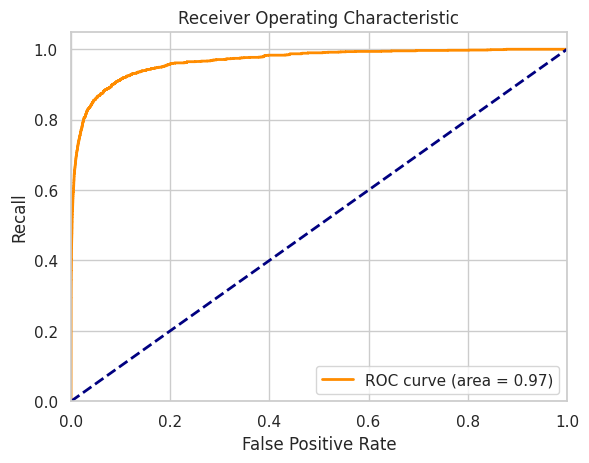

In [ ]:
y_pred = xgb_final.predict(xgdmat_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

print("ROC AUC:", roc_auc)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

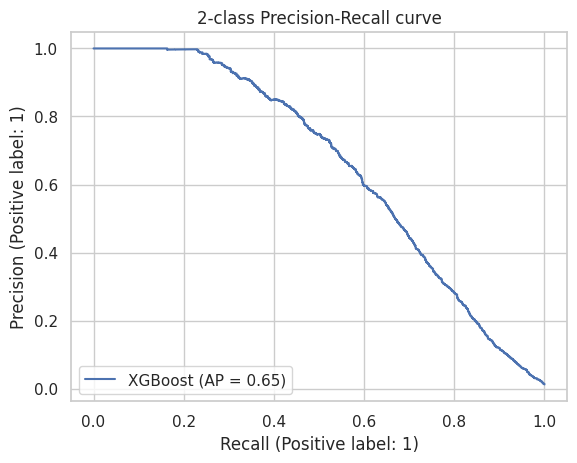

In [ ]:
display = PrecisionRecallDisplay.from_predictions(y_test, y_pred, name="XGBoost")
_ = display.ax_.set_title("2-class Precision-Recall curve")

####Results with Threshold 1

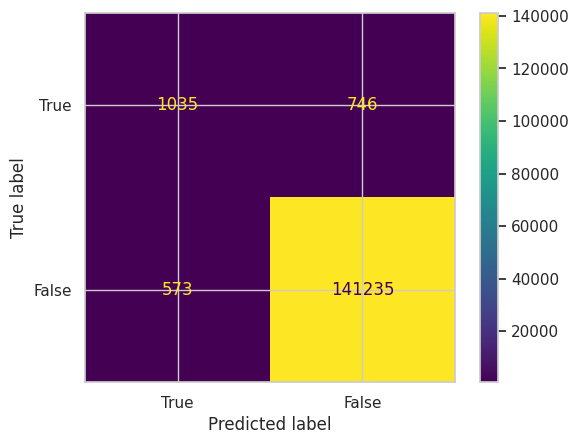

              precision    recall  f1-score   support

        True       0.64      0.58      0.61      1781
       False       0.99      1.00      1.00    141808

    accuracy                           0.99    143589
   macro avg       0.82      0.79      0.80    143589
weighted avg       0.99      0.99      0.99    143589



In [ ]:
labels = [True,False]
y_pred = xgb_final.predict(xgdmat_test)
f1=[]
y_temp = y_pred.copy()
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
f1 = 2*precision*recall/(precision+recall)
thresh = thresholds[np.argmax(f1)]
y_temp [y_pred > thresh] = True
y_temp [y_pred <= thresh] = False
cm = confusion_matrix(y_test, y_temp, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(classification_report(y_test, y_temp, labels=labels))

####Results with Threshold 2

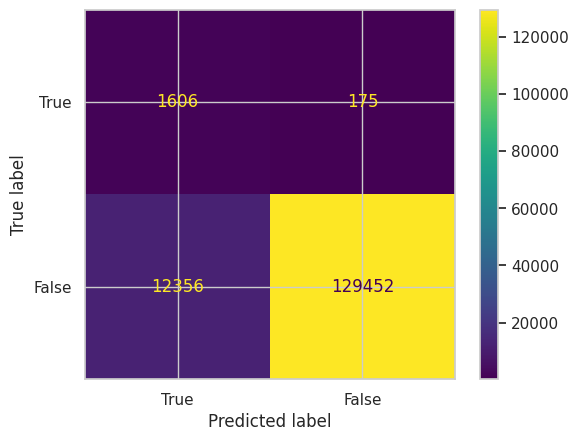

              precision    recall  f1-score   support

        True       0.12      0.90      0.20      1781
       False       1.00      0.91      0.95    141808

    accuracy                           0.91    143589
   macro avg       0.56      0.91      0.58    143589
weighted avg       0.99      0.91      0.94    143589



In [ ]:
labels = [True,False]
y_pred = xgb_final.predict(xgdmat_test)
f1=[]
y_temp = y_pred.copy()
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
f1 = 2*precision*recall/(precision+recall)
thresh = thresholds[np.argmax(f1)]
thresh=0.009
y_temp [y_pred > thresh] = True
y_temp [y_pred <= thresh] = False
cm = confusion_matrix(y_test, y_temp, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(classification_report(y_test, y_temp, labels=labels))

####Results with Threshold 3

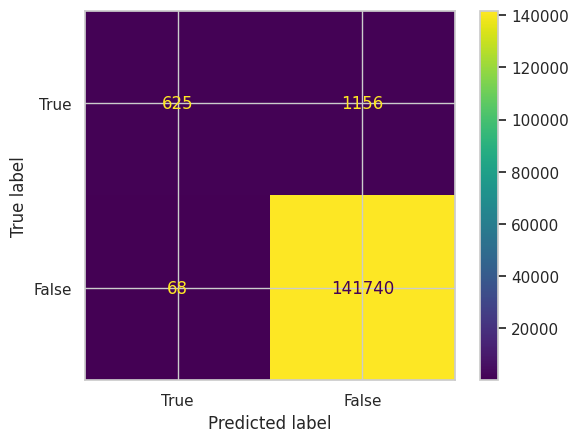

              precision    recall  f1-score   support

        True       0.90      0.35      0.51      1781
       False       0.99      1.00      1.00    141808

    accuracy                           0.99    143589
   macro avg       0.95      0.68      0.75    143589
weighted avg       0.99      0.99      0.99    143589



In [ ]:
labels = [True,False]
y_pred = xgb_final.predict(xgdmat_test)
f1=[]
y_temp = y_pred.copy()
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
f1 = 2*precision*recall/(precision+recall)
thresh = thresholds[np.argmax(f1)]
thresh=0.74
y_temp [y_pred > thresh] = True
y_temp [y_pred <= thresh] = False
cm = confusion_matrix(y_test, y_temp, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(classification_report(y_test, y_temp, labels=labels))

In [ ]:
xgb_final.save_model(os.path.join(dataset_path,'xgb_model.json'))

###Resampling for performance improvements (SMOTE)

[0]	validation_0-logloss:0.56939
[1]	validation_0-logloss:0.49469
[2]	validation_0-logloss:0.44041
[3]	validation_0-logloss:0.40594
[4]	validation_0-logloss:0.37956
[5]	validation_0-logloss:0.35893
[6]	validation_0-logloss:0.34451
[7]	validation_0-logloss:0.33360
[8]	validation_0-logloss:0.32265
[9]	validation_0-logloss:0.31661
[10]	validation_0-logloss:0.30635
[11]	validation_0-logloss:0.29962
[12]	validation_0-logloss:0.29443
[13]	validation_0-logloss:0.28866
[14]	validation_0-logloss:0.28268
[15]	validation_0-logloss:0.27828
[16]	validation_0-logloss:0.27199
[17]	validation_0-logloss:0.26993
[18]	validation_0-logloss:0.26587
[19]	validation_0-logloss:0.26185
[20]	validation_0-logloss:0.25766
[21]	validation_0-logloss:0.25497
[22]	validation_0-logloss:0.25333
[23]	validation_0-logloss:0.24855
[24]	validation_0-logloss:0.24627
[25]	validation_0-logloss:0.24327
[26]	validation_0-logloss:0.24188
[27]	validation_0-logloss:0.23854
[28]	validation_0-logloss:0.23373
[29]	validation_0-loglos

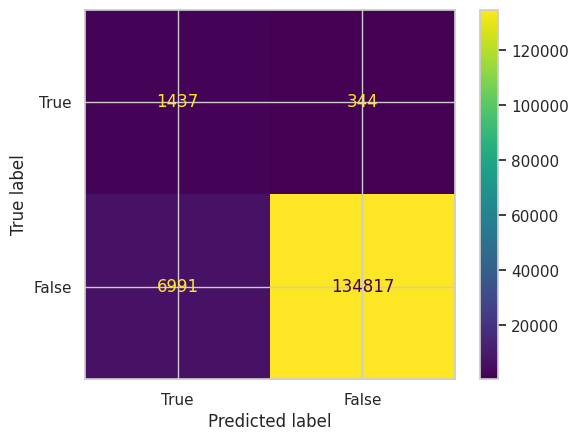

              precision    recall  f1-score   support

        True       0.17      0.81      0.28      1781
       False       1.00      0.95      0.97    141808

    accuracy                           0.95    143589
   macro avg       0.58      0.88      0.63    143589
weighted avg       0.99      0.95      0.96    143589



In [ ]:
model = xgb.XGBClassifier(early_stopping_rounds=2)
clf_xgb = make_pipeline(model)
x_train_xgb, x_eval_xgb, y_train_xgb, y_eval_xgb = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
x_train_xgb,y_train_xgb = resampler.fit_resample(x_train_xgb,y_train_xgb)
clf_xgb.fit(x_train_xgb, y_train_xgb, xgbclassifier__eval_set=[(x_eval_xgb, y_eval_xgb)])
y_pred = clf_xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred, labels=labels))

##Logistic Regression

ROC AUC: 0.7852068114906281


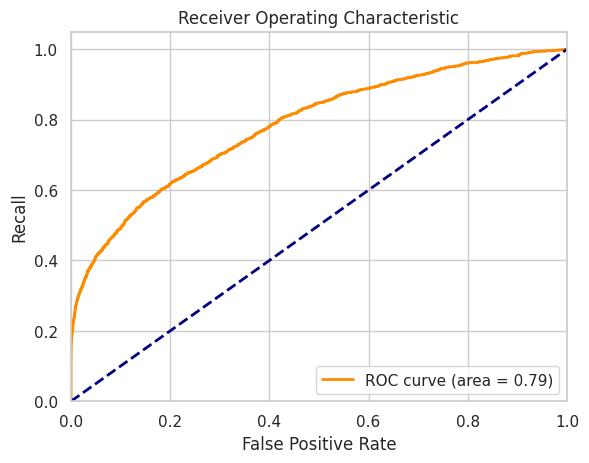

In [ ]:
clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=0))
clf.fit(X_train, y_train)
y_scores=clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
roc_auc = auc(fpr, tpr)

print("ROC AUC:", roc_auc)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


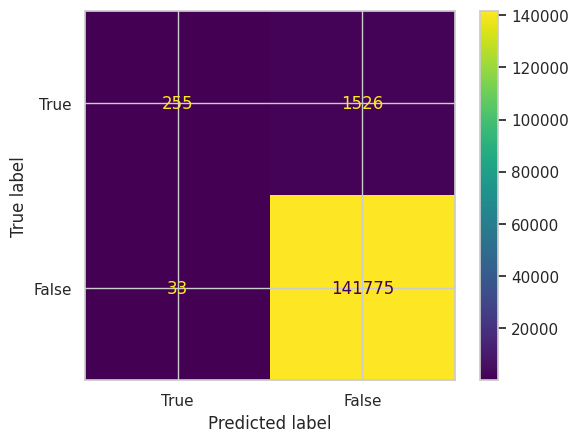

              precision    recall  f1-score   support

        True       0.89      0.14      0.25      1781
       False       0.99      1.00      0.99    141808

    accuracy                           0.99    143589
   macro avg       0.94      0.57      0.62    143589
weighted avg       0.99      0.99      0.99    143589



In [ ]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred, labels=labels))

ROC AUC: 0.828101747114017


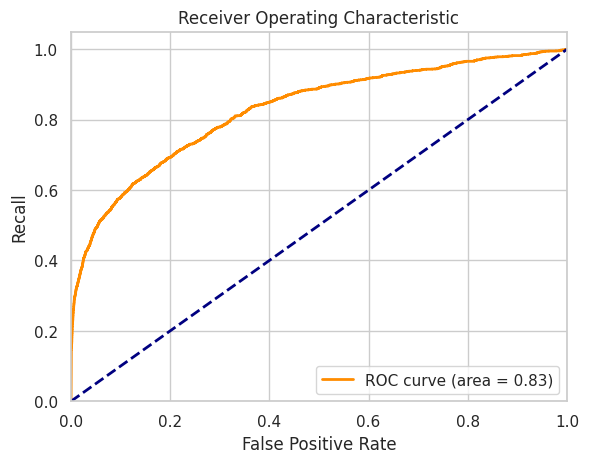

In [ ]:
clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=0))
clf.fit(x_res, y_res)
y_scores=clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
roc_auc = auc(fpr, tpr)

print("ROC AUC:", roc_auc)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


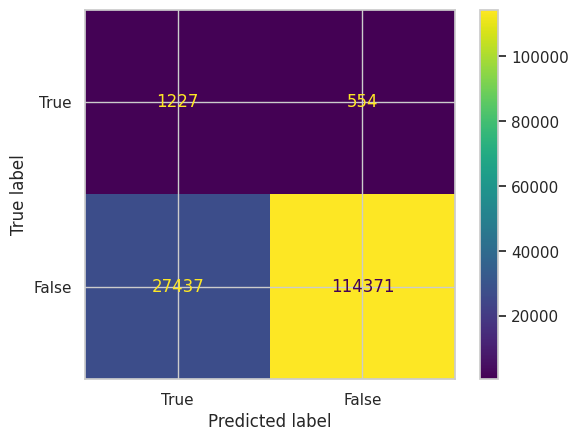

              precision    recall  f1-score   support

        True       0.04      0.69      0.08      1781
       False       1.00      0.81      0.89    141808

    accuracy                           0.81    143589
   macro avg       0.52      0.75      0.49    143589
weighted avg       0.98      0.81      0.88    143589



In [ ]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred, labels=labels))

##Naive Bayes

ROC AUC: 0.8037182606965612


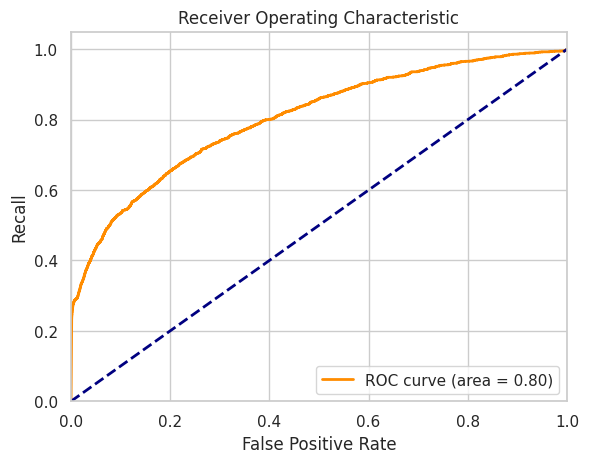

In [ ]:
clf = make_pipeline(StandardScaler(), GaussianNB())
clf.fit(X_train, y_train)
y_scores=clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
roc_auc = auc(fpr, tpr)

print("ROC AUC:", roc_auc)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

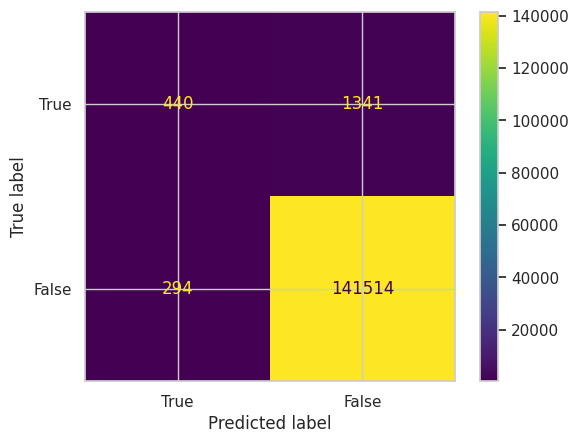

              precision    recall  f1-score   support

        True       0.60      0.25      0.35      1781
       False       0.99      1.00      0.99    141808

    accuracy                           0.99    143589
   macro avg       0.80      0.62      0.67    143589
weighted avg       0.99      0.99      0.99    143589



In [ ]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred, labels=labels))

ROC AUC: 0.8056452598551929


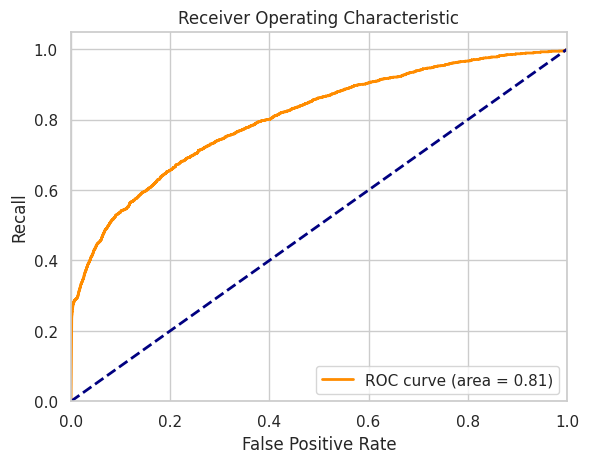

In [ ]:
clf = make_pipeline(StandardScaler(), GaussianNB())
clf.fit(x_res, y_res)
y_scores=clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
roc_auc = auc(fpr, tpr)

print("ROC AUC:", roc_auc)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

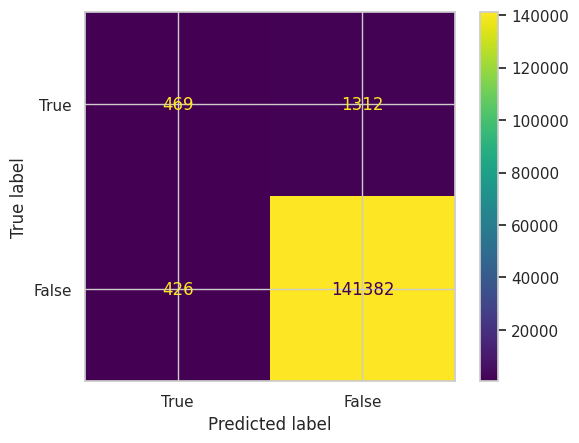

              precision    recall  f1-score   support

        True       0.52      0.26      0.35      1781
       False       0.99      1.00      0.99    141808

    accuracy                           0.99    143589
   macro avg       0.76      0.63      0.67    143589
weighted avg       0.99      0.99      0.99    143589



In [ ]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred, labels=labels))

ROC AUC: 0.7331588486235955


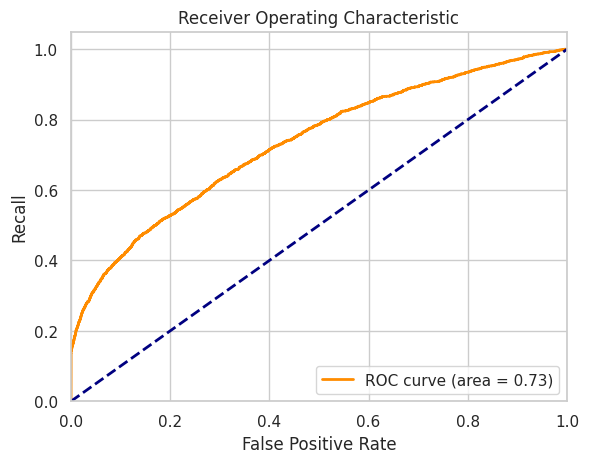

In [ ]:
clf = make_pipeline(MinMaxScaler(), ComplementNB())
clf.fit(X_train, y_train)
y_scores=clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
roc_auc = auc(fpr, tpr)

print("ROC AUC:", roc_auc)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

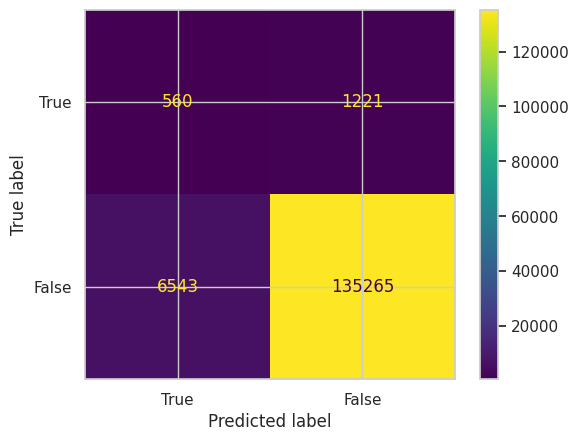

              precision    recall  f1-score   support

        True       0.08      0.31      0.13      1781
       False       0.99      0.95      0.97    141808

    accuracy                           0.95    143589
   macro avg       0.53      0.63      0.55    143589
weighted avg       0.98      0.95      0.96    143589



In [ ]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred, labels=labels))

ROC AUC: 0.7326889009777192


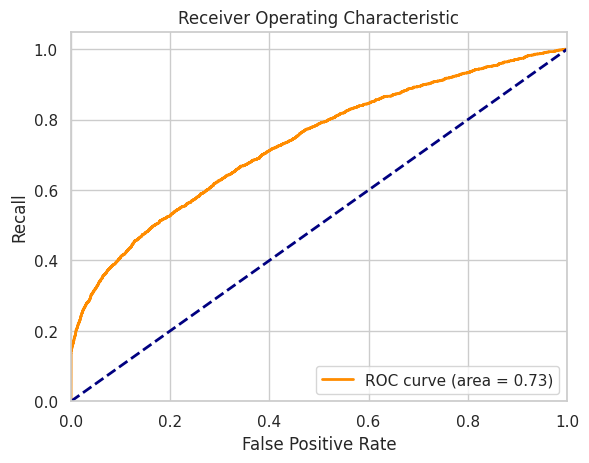

In [ ]:
clf = make_pipeline(MinMaxScaler(), ComplementNB())
clf.fit(x_res, y_res)
y_scores=clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
roc_auc = auc(fpr, tpr)

print("ROC AUC:", roc_auc)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

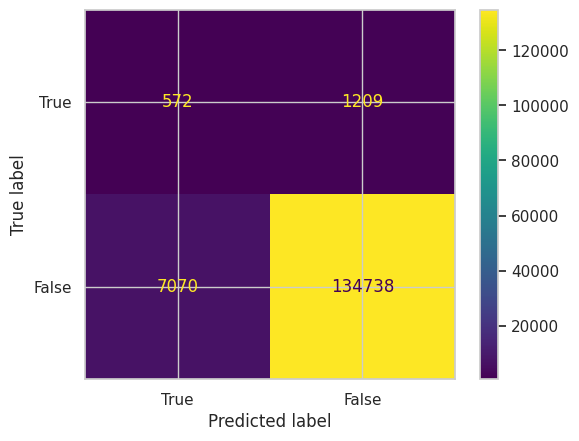

              precision    recall  f1-score   support

        True       0.07      0.32      0.12      1781
       False       0.99      0.95      0.97    141808

    accuracy                           0.94    143589
   macro avg       0.53      0.64      0.55    143589
weighted avg       0.98      0.94      0.96    143589



In [ ]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred, labels=labels))

##Neural Network

In [ ]:
train_df, validation_df = train_test_split(train_df, test_size=0.3, stratify=train_df['disrupt_30ms'], random_state=42)

In [ ]:
X_train = np.array(train_df.drop(columns=["disrupt_30ms"]))
y_train = np.array(train_df["disrupt_30ms"])
X_val = np.array(validation_df.drop(columns=["disrupt_30ms"]))
y_val = np.array(validation_df["disrupt_30ms"])
X_test = np.array(test_df.drop(columns=["disrupt_30ms"]))
y_test = np.array(test_df["disrupt_30ms"])

In [ ]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
metrics = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
pos = sum(y_train==True)
neg = sum(y_train==False)
initial_bias = np.log([pos/neg])
output_bias = tf.keras.initializers.Constant(initial_bias)

In [ ]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.5),
    Dense(8, activation='relu'),
    keras.layers.Dropout(0.5),
    Dense(1, activation='sigmoid', bias_initializer=output_bias)  # Sigmoid activation for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

In [ ]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_recall',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 32)                416       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 8)                 264       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_10 (Dense)            (None, 1)                 9         
                                                                 
Total params: 689 (2.69 KB)
Trainable params: 689 (2.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs=100, callbacks=[early_stopping], validation_data=(X_val,y_val))

Epoch 1/100
7329/7329 [==============================] - 31s 4ms/step - loss: 0.0572 - cross entropy: 0.0516 - Brier score: 0.0099 - tp: 787.0000 - fp: 161.0000 - tn: 330723.0000 - fn: 3370.0000 - accuracy: 0.9895 - precision: 0.8302 - recall: 0.1893 - auc: 0.7981 - prc: 0.2932 - val_loss: 0.0528 - val_cross entropy: 0.0528 - val_Brier score: 0.0103 - val_tp: 185.0000 - val_fp: 17.0000 - val_tn: 99249.0000 - val_fn: 1062.0000 - val_accuracy: 0.9893 - val_precision: 0.9158 - val_recall: 0.1484 - val_auc: 0.8301 - val_prc: 0.3080
Epoch 2/100
7329/7329 [==============================] - 27s 4ms/step - loss: 0.0528 - cross entropy: 0.0528 - Brier score: 0.0100 - tp: 522.0000 - fp: 74.0000 - tn: 231544.0000 - fn: 2388.0000 - accuracy: 0.9895 - precision: 0.8758 - recall: 0.1794 - auc: 0.7935 - prc: 0.2787 - val_loss: 0.0505 - val_cross entropy: 0.0505 - val_Brier score: 0.0099 - val_tp: 216.0000 - val_fp: 19.0000 - val_tn: 99247.0000 - val_fn: 1031.0000 - val_accuracy: 0.9896 - val_precisio

In [ ]:
model.save(os.path.join(dataset_path,'nn.keras'))

4488/4488 [==============================] - 7s 2ms/step
ROC AUC: 0.9157343108360511


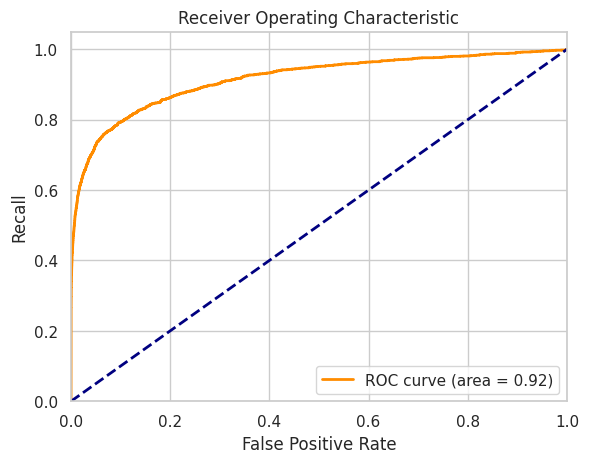

In [ ]:
y_pred = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

print("ROC AUC:", roc_auc)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

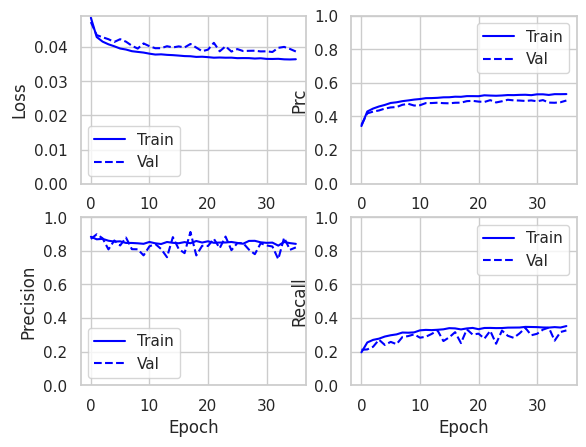

In [ ]:
plot_metrics(history)

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

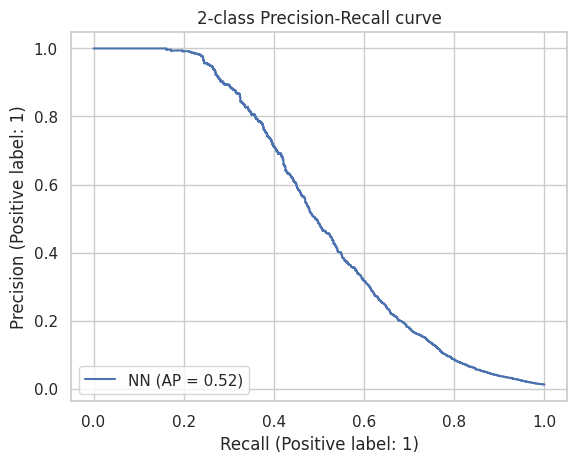

In [ ]:
display = PrecisionRecallDisplay.from_predictions(y_test, y_pred, name="NN")
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [ ]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.5),
    Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    Dense(16,activation='relu'),
    keras.layers.Dropout(0.5),
    Dense(1, activation='sigmoid', bias_initializer=output_bias)  # Sigmoid activation for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

In [ ]:
#history = model.fit(X_train, y_train, epochs=100, callbacks=[early_stopping], validation_data=(X_val,y_val))

Epoch 1/100
7329/7329 [==============================] - 61s 8ms/step - loss: 0.0580 - cross entropy: 0.0544 - Brier score: 0.0102 - tp: 653.0000 - fp: 94.0000 - tn: 330790.0000 - fn: 3504.0000 - accuracy: 0.9893 - precision: 0.8742 - recall: 0.1571 - auc: 0.7993 - prc: 0.2724 - val_loss: 0.0522 - val_cross entropy: 0.0522 - val_Brier score: 0.0102 - val_tp: 193.0000 - val_fp: 18.0000 - val_tn: 99248.0000 - val_fn: 1054.0000 - val_accuracy: 0.9893 - val_precision: 0.9147 - val_recall: 0.1548 - val_auc: 0.8461 - val_prc: 0.3182
Epoch 2/100
7329/7329 [==============================] - 64s 9ms/step - loss: 0.0517 - cross entropy: 0.0517 - Brier score: 0.0099 - tp: 575.0000 - fp: 98.0000 - tn: 231520.0000 - fn: 2335.0000 - accuracy: 0.9896 - precision: 0.8544 - recall: 0.1976 - auc: 0.8188 - prc: 0.2972 - val_loss: 0.0506 - val_cross entropy: 0.0506 - val_Brier score: 0.0101 - val_tp: 202.0000 - val_fp: 22.0000 - val_tn: 99244.0000 - val_fn: 1045.0000 - val_accuracy: 0.9894 - val_precision

In [ ]:
#model.save(os.path.join(dataset_path,'nn2.keras'))

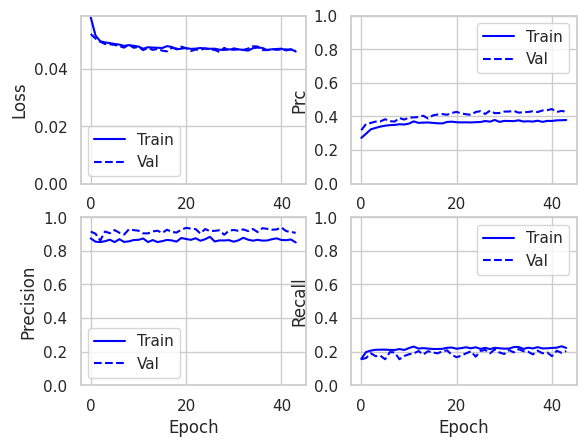

In [ ]:
plot_metrics(history)

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

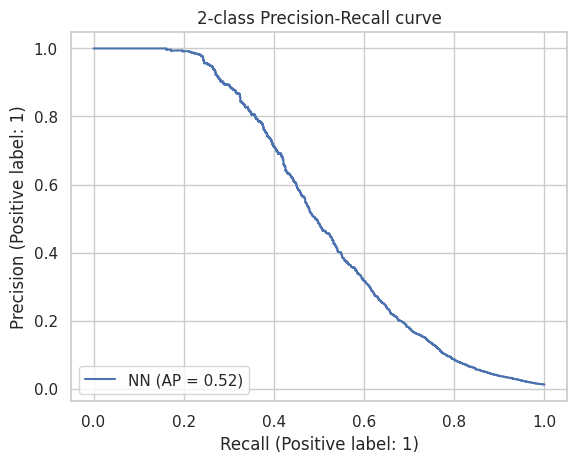

In [ ]:
display = PrecisionRecallDisplay.from_predictions(y_test, y_pred, name="NN")
_ = display.ax_.set_title("2-class Precision-Recall curve")

#Time-Series Analysis

Even though the use of several time steps allowed for a performance increase, considering the time steps of 5 ms, it was not deemed adequate for the application, that requires identification of disruption within 30ms

In [ ]:
timesteps=3

In [ ]:
df.head()

Greenwald_fraction  Mirnov_norm_btor    beta_p  \
shot       time                                                     
1150915029 0.2850        2.616714e-01          1.239055  0.147276   
           0.2900        1.936365e-01          1.153987  0.199118   
           0.2950        3.123977e-21          3.540942 -0.014039   
1120131006 0.1895        1.853891e-01          0.208537  0.001086   
           0.1945        1.804675e-01          0.194072  0.024498   

                   ip_error_normalized     kappa        li  lower_gap  \
shot       time                                                         
1150915029 0.2850            -0.155933  1.572284  1.440702   0.071738   
           0.2900            -0.214753  1.553859  1.470170   0.077982   
           0.2950            -0.660401  1.691133  1.032967   0.088654   
1120131006 0.1895            -0.264637  1.331522  1.553290   0.094562   
           0.1945            -0.246736  1.388904  1.564471   0.106611   

                   n_equal_1_normalized       q95  radiated_fraction  \
shot       time                                                        
1150915029 0.2850              0.000885  5.205303           0.408387   
           0.2900              0.001154  5.151639           1.701884   
           0.2950              0.003092  5.954643           0.276097   
1120131006 0.1895              0.001163  4.707932           0.665236   
           0.1945              0.001136  4.985343           0.510057   

                     v_loop   z_error  disrupt_30ms  
shot       time                                      
1150915029 0.2850  4.186112 -0.004279          True  
           0.2900  3.770813  0.000107          True  
           0.2950  7.111877  0.004702          True  
1120131006 0.1895 -2.671509 -0.007156          True  
           0.1945 -2.581421 -0.018531          True

##Analysis of time deltas in the dataset

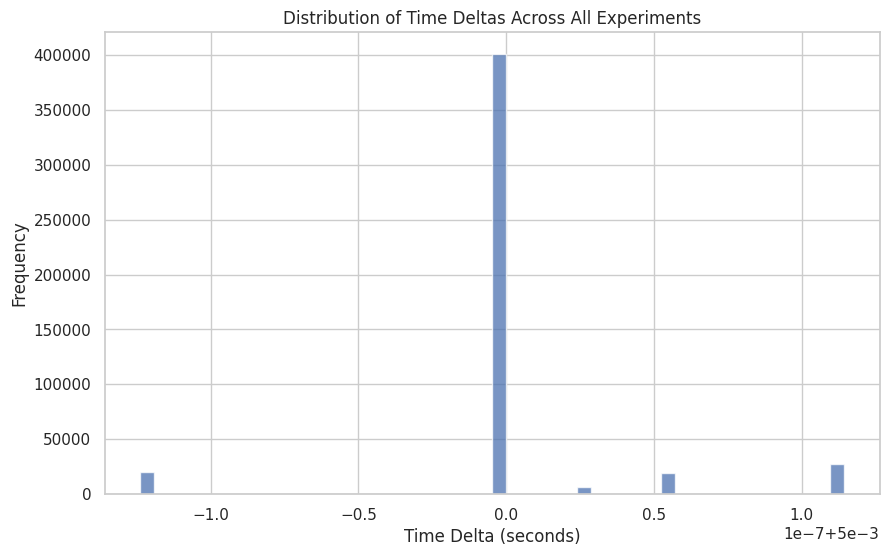

In [ ]:
experiments = df.index.get_level_values('shot').unique()

time_deltas = []

for experiment in experiments:
    experiment_data = df.loc[experiment].sort_index()

    if len(experiment_data) > 1:
        deltas = experiment_data.index.to_series().diff().dropna()
        time_deltas.extend(deltas)

time_delta_series = pd.Series(time_deltas)

plt.figure(figsize=(10, 6))
time_delta_series.plot(kind='hist', bins=50, alpha=0.75)
plt.title('Distribution of Time Deltas Across All Experiments')
plt.xlabel('Time Delta (seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

##Creation of squeezed DataFrame

In [ ]:
filtered_dataframes = []

for experiment in experiments:
    experiment_data = df.loc[experiment]

    if len(experiment_data) >= 3:
        for start_idx in range(len(experiment_data) - 2):  # minus 2 to ensure three items
            sub_series = experiment_data.iloc[start_idx:start_idx + 3]
            filtered_dataframes.append(sub_series)

if filtered_dataframes:
    complete_time_series_dataset = pd.concat(filtered_dataframes)
else:
    complete_time_series_dataset = pd.DataFrame()  # in case no experiment has 3 or more data points

print(complete_time_series_dataset)


        Greenwald_fraction  Mirnov_norm_btor    beta_p  ip_error_normalized  \
time                                                                          
0.2850        2.616714e-01          1.239055  0.147276            -0.155933   
0.2900        1.936365e-01          1.153987  0.199118            -0.214753   
0.2950        3.123977e-21          3.540942 -0.014039            -0.660401   
0.1895        1.853891e-01          0.208537  0.001086            -0.264637   
0.1945        1.804675e-01          0.194072  0.024498            -0.246736   
...                    ...               ...       ...                  ...   
1.8450        1.674249e-01          0.167850  0.097268            -0.014955   
1.8500        1.697881e-01          0.188453  0.105031            -0.011484   
1.8450        1.674249e-01          0.167850  0.097268            -0.014955   
1.8500        1.697881e-01          0.188453  0.105031            -0.011484   
1.8550        1.660342e-01          0.171037  0.0996

In [ ]:
def extract_time_series_features(data, window_size=3):
  features = []
  labels = []
  experiments = data.index.get_level_values('shot').unique()
  for experiment in experiments:
    experiment_data = data.loc[experiment].sort_index()

    for start_idx in range(len(experiment_data) - window_size + 1):
      sub_series = experiment_data.iloc[start_idx:start_idx + window_size]
      feature_vector = {}
      label=False
      for t in range(window_size):
        if sub_series.iloc[t]["disrupt_30ms"]==True:
          label=True
        timestep_data = sub_series.iloc[t]
        for col in timestep_data.index:
          if col != 'disrupt_30ms':
            feature_vector[f'{col}_t{t+1}'] = timestep_data[col]
        features.append(feature_vector)
        labels.append(label)

  feature_df = pd.DataFrame(features)
  if labels:
      feature_df['label'] = labels
  return feature_df

final_dataset = extract_time_series_features(df)

print(final_dataset.head())

   Greenwald_fraction_t1  Mirnov_norm_btor_t1  beta_p_t1  \
0               0.261671             1.239055   0.147276   
1               0.261671             1.239055   0.147276   
2               0.261671             1.239055   0.147276   
3               0.185389             0.208537   0.001086   
4               0.185389             0.208537   0.001086   

   ip_error_normalized_t1  kappa_t1     li_t1  lower_gap_t1  \
0               -0.155933  1.572284  1.440702      0.071738   
1               -0.155933  1.572284  1.440702      0.071738   
2               -0.155933  1.572284  1.440702      0.071738   
3               -0.264637  1.331522  1.553290      0.094562   
4               -0.264637  1.331522  1.553290      0.094562   

   n_equal_1_normalized_t1    q95_t1  radiated_fraction_t1  ...  \
0                 0.000885  5.205303              0.408387  ...   
1                 0.000885  5.205303              0.408387  ...   
2                 0.000885  5.205303              0.408387 

In [ ]:
final_dataset.head()

,Greenwald_fraction_t1,Mirnov_norm_btor_t1,beta_p_t1,ip_error_normalized_t1,kappa_t1,li_t1,lower_gap_t1,n_equal_1_normalized_t1,q95_t1,radiated_fraction_t1,...,ip_error_normalized_t3,kappa_t3,li_t3,lower_gap_t3,n_equal_1_normalized_t3,q95_t3,radiated_fraction_t3,v_loop_t3,z_error_t3,label
0,0.261671,1.239055,0.147276,-0.155933,1.572284,1.440702,0.071738,0.000885,5.205303,0.408387,...,-0.660401,1.691133,1.032967,0.088654,0.003092,5.954643,0.276097,7.111877,0.004702,True
1,0.261671,1.239055,0.147276,-0.155933,1.572284,1.440702,0.071738,0.000885,5.205303,0.408387,...,-0.660401,1.691133,1.032967,0.088654,0.003092,5.954643,0.276097,7.111877,0.004702,True
2,0.261671,1.239055,0.147276,-0.155933,1.572284,1.440702,0.071738,0.000885,5.205303,0.408387,...,-0.660401,1.691133,1.032967,0.088654,0.003092,5.954643,0.276097,7.111877,0.004702,True
3,0.185389,0.208537,0.001086,-0.264637,1.331522,1.553290,0.094562,0.001163,4.707932,0.665236,...,-0.246112,1.408663,1.599655,0.162560,0.001044,4.883385,0.257052,-2.445080,-0.067207,True
4,0.185389,0.208537,0.001086,-0.264637,1.331522,1.553290,0.094562,0.001163,4.707932,0.665236,...,-0.246112,1.408663,1.599655,0.162560,0.001044,4.883385,0.257052,-2.445080,-0.067207,True


In [ ]:
final_dataset["label"].value_counts()

label
False    1394073
True       14829
Name: count, dtype: int64

##Squeezed Dataframe Train Test split

In [ ]:
train_df, test_df = train_test_split(final_dataset, test_size=0.3, stratify=final_dataset["label"], random_state=42)

In [ ]:
X_train = np.array(train_df.drop(columns=["label"]))
y_train = np.array(train_df["label"])
X_test = np.array(test_df.drop(columns=["label"]))
y_test = np.array(test_df["label"])
print(X_train, y_train)

[[ 2.56895006e-01  1.80754113e+00  1.31867766e-01 ...  4.16245759e-02
  -1.05352783e+00 -4.01920901e-04]
 [ 1.47965699e-01  1.51076138e-01  1.19776011e-01 ...  6.77781925e-02
  -1.45269775e+00  1.31992309e-03]
 [ 4.89388824e-01  8.48786831e-01  3.89988065e-01 ...  3.04514378e-01
   4.35485840e-02  8.39019427e-04]
 ...
 [ 2.56947249e-01  1.45944834e+00  2.71829963e-01 ...  3.60637665e-01
  -3.77029419e-01  8.68927571e-04]
 [ 3.84365648e-01  7.53928542e-01  3.62177223e-01 ...  4.81570363e-01
  -6.04980469e-01  1.66996825e-03]
 [ 1.29698947e-01  4.57371958e-02  3.00639868e-01 ...  1.71659350e-01
   4.18426514e-01 -1.90091378e-04]] [False False False ... False False False]


##Anomaly Detection

###Isolation Forest

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_train)

In [ ]:
isolation_forest = IsolationForest(max_samples=100, random_state=42)
isolation_forest.fit(scaled_data)

IsolationForest(max_samples=100, random_state=42)

In [ ]:
y_pred = isolation_forest.predict(scaled_data)
print(y_pred)
print(np.unique(y_pred,return_counts=True))

[1 1 1 ... 1 1 1]
(array([-1,  1]), array([ 66895, 919336]))


In [ ]:
y_train_isfor=y_train.astype(int)*(-2)+1
print(y_train_isfor)
print(np.unique(y_train_isfor,return_counts=True))

[1 1 1 ... 1 1 1]
(array([-1,  1]), array([ 10380, 975851]))


In [ ]:
cm = confusion_matrix(y_train_isfor, y_pred, labels=[1, -1])

precision = precision_score(y_train_isfor, y_pred, pos_label=-1)
recall = recall_score(y_train_isfor, y_pred, pos_label=-1)

print("Confusion Matrix:")
print(cm)
print(f"\nPrecision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

print("\nClassification Report:")
print(classification_report(y_train, y_pred, labels=[1, -1], target_names=['Normal', 'Anomalous']))

Confusion Matrix:
[[913209  62642]
 [  6127   4253]]

Precision: 0.06
Recall: 0.41

Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      Normal       0.01      0.59      0.01     10380
   Anomalous       0.00      0.00      0.00         0

   micro avg       0.01      0.59      0.01     10380
   macro avg       0.00      0.30      0.01     10380
weighted avg       0.01      0.59      0.01     10380



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


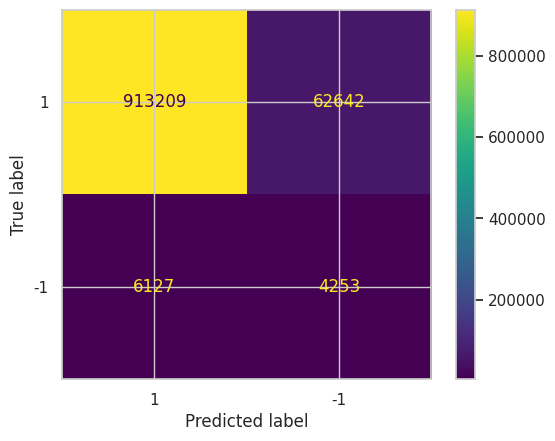

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,-1])
disp.plot()
plt.show()

##Classification

###Linear SVM

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


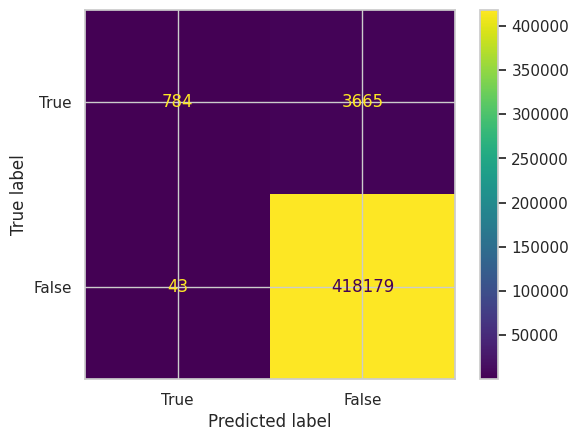

              precision    recall  f1-score   support

        True       0.95      0.18      0.30      4449
       False       0.99      1.00      1.00    418222

    accuracy                           0.99    422671
   macro avg       0.97      0.59      0.65    422671
weighted avg       0.99      0.99      0.99    422671



In [ ]:
clf = make_pipeline(StandardScaler(), LinearSVC(dual=False,
                                                random_state=0, tol=1e-5))
labels = [True,False]
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
precision, recall, fscore, support = precision_recall_fscore_support(y_test,y_pred, labels=labels)
cm=confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred, labels=labels))

###SVM

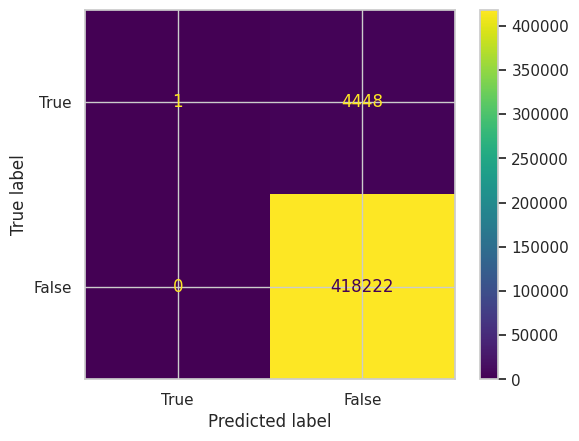

              precision    recall  f1-score   support

        True       1.00      0.00      0.00      4449
       False       0.99      1.00      0.99    418222

    accuracy                           0.99    422671
   macro avg       0.99      0.50      0.50    422671
weighted avg       0.99      0.99      0.98    422671



In [ ]:
rescaler = StandardScaler()
clf = make_pipeline(StandardScaler(), Nystroem(gamma=.2, random_state=0, n_components=300), LinearSVC(dual=False, random_state=0))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
precision, recall, fscore, support = precision_recall_fscore_support(y_test,y_pred, labels=labels)
cm=confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred, labels=labels))

###XGBoost

[0]	validation_0-logloss:0.11546
[1]	validation_0-logloss:0.09155
[2]	validation_0-logloss:0.07415
[3]	validation_0-logloss:0.06191
[4]	validation_0-logloss:0.05315
[5]	validation_0-logloss:0.04669
[6]	validation_0-logloss:0.04179
[7]	validation_0-logloss:0.03817
[8]	validation_0-logloss:0.03552
[9]	validation_0-logloss:0.03348
[10]	validation_0-logloss:0.03187
[11]	validation_0-logloss:0.03051
[12]	validation_0-logloss:0.02954
[13]	validation_0-logloss:0.02877
[14]	validation_0-logloss:0.02798
[15]	validation_0-logloss:0.02739
[16]	validation_0-logloss:0.02680
[17]	validation_0-logloss:0.02621
[18]	validation_0-logloss:0.02582
[19]	validation_0-logloss:0.02547
[20]	validation_0-logloss:0.02506
[21]	validation_0-logloss:0.02479
[22]	validation_0-logloss:0.02455
[23]	validation_0-logloss:0.02417
[24]	validation_0-logloss:0.02389
[25]	validation_0-logloss:0.02357
[26]	validation_0-logloss:0.02337
[27]	validation_0-logloss:0.02318
[28]	validation_0-logloss:0.02302
[29]	validation_0-loglos

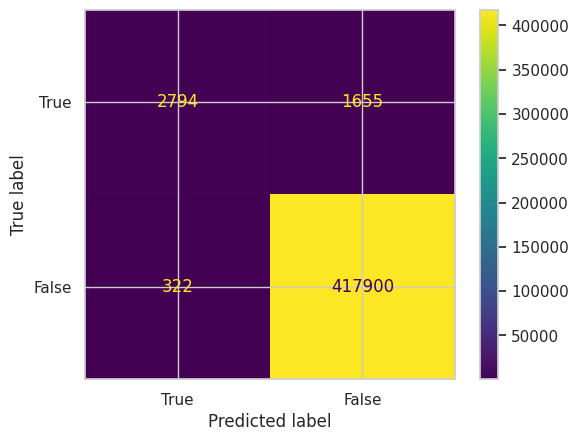

              precision    recall  f1-score   support

        True       0.90      0.63      0.74      4449
       False       1.00      1.00      1.00    418222

    accuracy                           1.00    422671
   macro avg       0.95      0.81      0.87    422671
weighted avg       1.00      1.00      0.99    422671



In [ ]:
model = xgb.XGBClassifier(early_stopping_rounds=2)
clf_xgb = make_pipeline(model)
x_train_xgb, x_eval_xgb, y_train_xgb, y_eval_xgb = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
clf_xgb.fit(x_train_xgb, y_train_xgb, xgbclassifier__eval_set=[(x_eval_xgb, y_eval_xgb)])
y_pred = clf_xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred, labels=labels))

###Logistic Regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC AUC: 0.8583258551387003


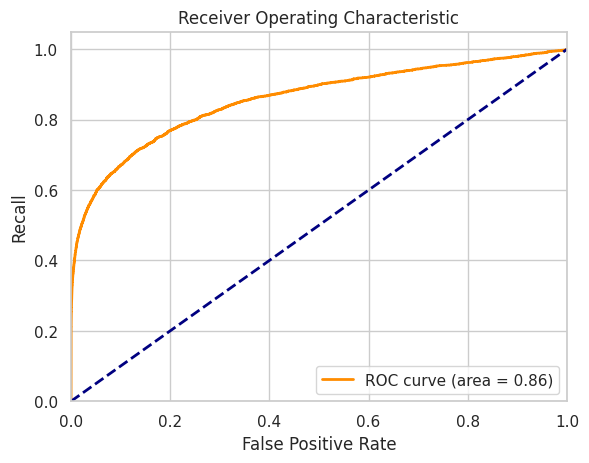

In [ ]:
clf = make_pipeline(StandardScaler(), LogisticRegression(random_state=0))
clf.fit(X_train, y_train)
y_scores=clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
roc_auc = auc(fpr, tpr)

print("ROC AUC:", roc_auc)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


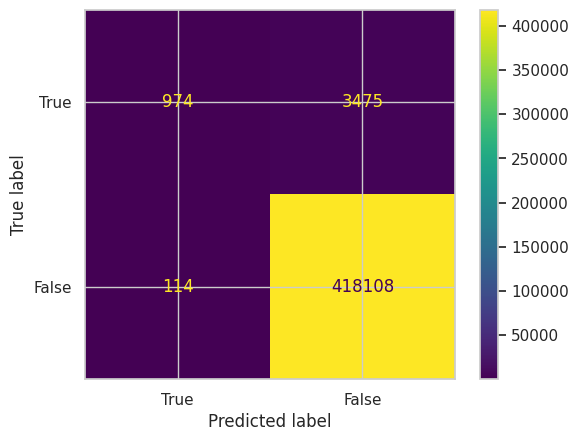

              precision    recall  f1-score   support

        True       0.90      0.22      0.35      4449
       False       0.99      1.00      1.00    418222

    accuracy                           0.99    422671
   macro avg       0.94      0.61      0.67    422671
weighted avg       0.99      0.99      0.99    422671



In [ ]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred, labels=labels))

###Naive Bayes

ROC AUC: 0.8485699072052059


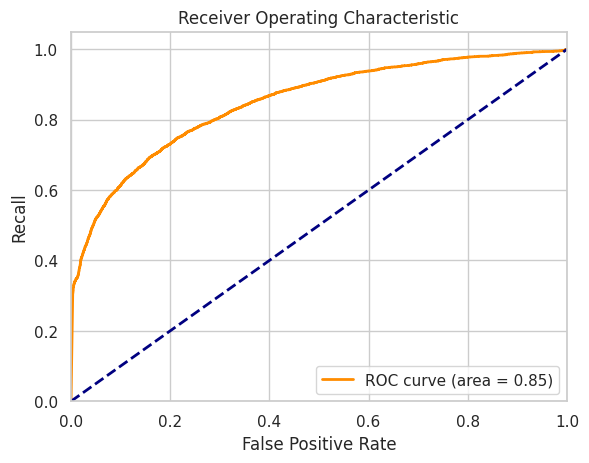

In [ ]:
clf = make_pipeline(StandardScaler(), GaussianNB())
clf.fit(X_train, y_train)
y_scores=clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
roc_auc = auc(fpr, tpr)

print("ROC AUC:", roc_auc)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

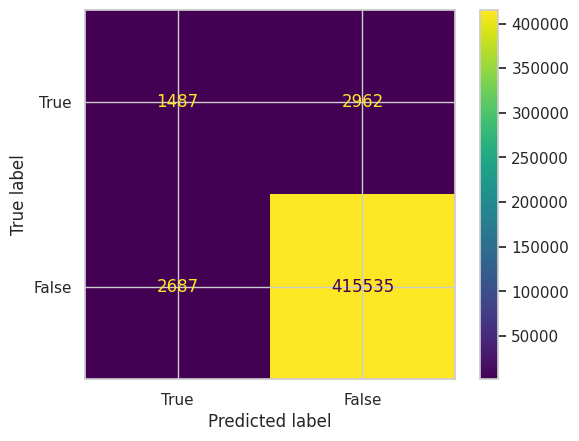

              precision    recall  f1-score   support

        True       0.36      0.33      0.34      4449
       False       0.99      0.99      0.99    418222

    accuracy                           0.99    422671
   macro avg       0.67      0.66      0.67    422671
weighted avg       0.99      0.99      0.99    422671



In [ ]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred, labels=labels))

ROC AUC: 0.7492679318548019


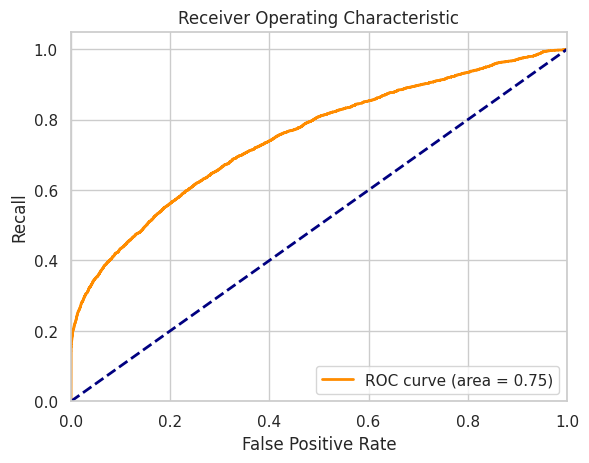

In [ ]:
clf = make_pipeline(MinMaxScaler(), ComplementNB())
clf.fit(X_train, y_train)
y_scores=clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
roc_auc = auc(fpr, tpr)

print("ROC AUC:", roc_auc)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

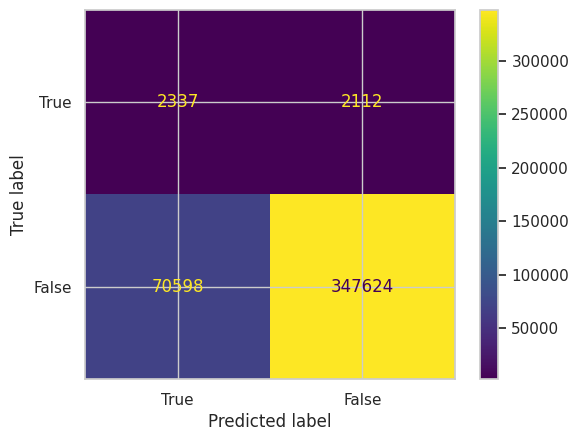

              precision    recall  f1-score   support

        True       0.03      0.53      0.06      4449
       False       0.99      0.83      0.91    418222

    accuracy                           0.83    422671
   macro avg       0.51      0.68      0.48    422671
weighted avg       0.98      0.83      0.90    422671



In [ ]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred, labels=labels))

###Neural Network

In [ ]:
train_df, validation_df = train_test_split(train_df, test_size=0.3, stratify=train_df['label'], random_state=42)

In [ ]:
X_train = np.array(train_df.drop(columns=["label"]))
y_train = np.array(train_df["label"])
X_val = np.array(validation_df.drop(columns=["label"]))
y_val = np.array(validation_df["label"])
X_test = np.array(test_df.drop(columns=["label"]))
y_test = np.array(test_df["label"])

In [ ]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
metrics = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
pos = sum(y_train==True)
neg = sum(y_train==False)
initial_bias = np.log([pos/neg])
output_bias = tf.keras.initializers.Constant(initial_bias)

In [ ]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.5),
    Dense(8, activation='relu'),
    keras.layers.Dropout(0.5),
    Dense(1, activation='sigmoid', bias_initializer=output_bias)  # Sigmoid activation for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

In [ ]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_recall',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1184      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1457 (5.69 KB)
Trainable params: 1457 (5.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs=100, callbacks=[early_stopping], validation_data=(X_val,y_val))

Epoch 1/100
21574/21574 [==============================] - 81s 4ms/step - loss: 0.0465 - cross entropy: 0.0465 - Brier score: 0.0086 - tp: 1261.0000 - fp: 263.0000 - tn: 682832.0000 - fn: 6005.0000 - accuracy: 0.9909 - precision: 0.8274 - recall: 0.1735 - auc: 0.8005 - prc: 0.2719 - val_loss: 0.0382 - val_cross entropy: 0.0382 - val_Brier score: 0.0077 - val_tp: 712.0000 - val_fp: 42.0000 - val_tn: 292714.0000 - val_fn: 2402.0000 - val_accuracy: 0.9917 - val_precision: 0.9443 - val_recall: 0.2286 - val_auc: 0.8889 - val_prc: 0.4654
Epoch 2/100
21574/21574 [==============================] - 84s 4ms/step - loss: 0.0417 - cross entropy: 0.0417 - Brier score: 0.0080 - tp: 1636.0000 - fp: 328.0000 - tn: 682767.0000 - fn: 5630.0000 - accuracy: 0.9914 - precision: 0.8330 - recall: 0.2252 - auc: 0.8533 - prc: 0.3552 - val_loss: 0.0354 - val_cross entropy: 0.0354 - val_Brier score: 0.0073 - val_tp: 820.0000 - val_fp: 72.0000 - val_tn: 292684.0000 - val_fn: 2294.0000 - val_accuracy: 0.9920 - val

In [ ]:
model.save(os.path.join(dataset_path,'nnseries.keras'))

13209/13209 [==============================] - 21s 2ms/step
ROC AUC: 0.9293784538686934


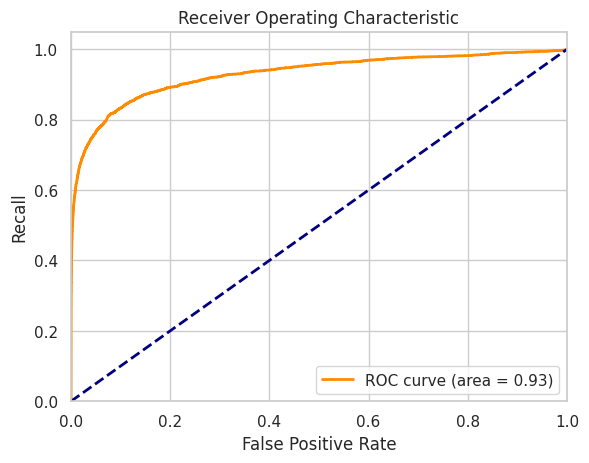

In [ ]:
y_pred = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

print("ROC AUC:", roc_auc)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
              linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

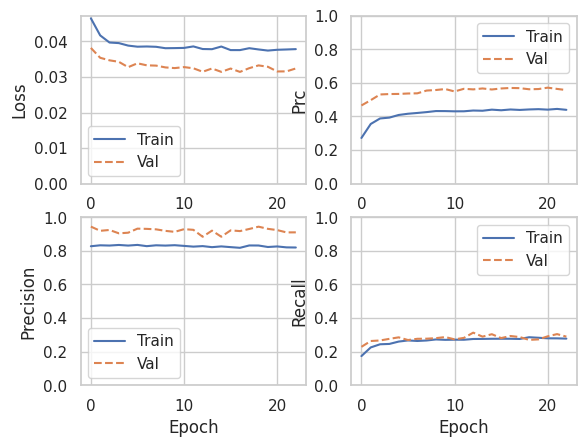

In [ ]:
plot_metrics(history)

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

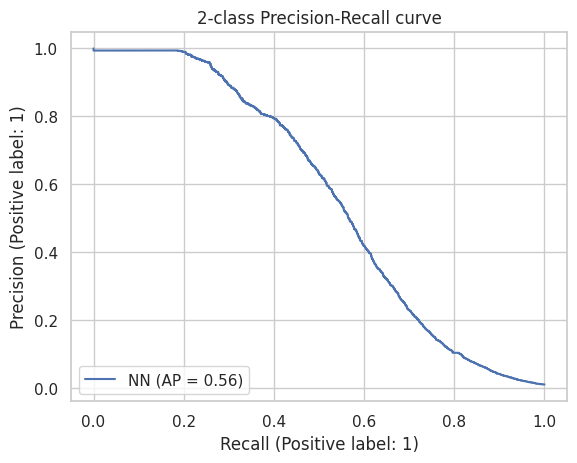

In [ ]:
display = PrecisionRecallDisplay.from_predictions(y_test, y_pred, name="NN")
_ = display.ax_.set_title("2-class Precision-Recall curve")

###LSTM

The use of LSTM requires a different structure of the data, resulting in three different time-steps

In [ ]:
def prepare_sequences(data, window_size=3):
  sequences = []
  labels = []

  experiments = data.index.get_level_values('shot').unique()
  for experiment in experiments:
    experiment_data = data.loc[experiment].sort_index()
    for start_idx in range(len(experiment_data) - window_size + 1):
      sub_series = experiment_data.iloc[start_idx:start_idx + window_size]
      if any(sub_series["disrupt_30ms"]):
        label=True
      else:
        label=False
      sequences.append(sub_series.drop(columns='disrupt_30ms').values)
      labels.append(label)

  return np.array(sequences), np.array(labels)

X, y = prepare_sequences(df, window_size=3)

scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [ ]:
metrics = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
pos = sum(y_train==True)
neg = sum(y_train==False)
initial_bias = np.log([pos/neg])
output_bias = tf.keras.initializers.Constant(initial_bias)

In [ ]:
model = Sequential([
    LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1, activation='sigmoid', bias_initializer=output_bias)  # Sigmoid activation for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

In [ ]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                5760      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5793 (22.63 KB)
Trainable params: 5793 (22.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs=100, callbacks=[early_stopping], validation_data=(X_val,y_val))

Epoch 1/100
7192/7192 [==============================] - 46s 6ms/step - loss: 0.0454 - cross entropy: 0.0454 - Brier score: 0.0094 - tp: 601.0000 - fp: 113.0000 - tn: 227120.0000 - fn: 2286.0000 - accuracy: 0.9896 - precision: 0.8417 - recall: 0.2082 - auc: 0.8650 - prc: 0.3788 - val_loss: 0.0390 - val_cross entropy: 0.0390 - val_Brier score: 0.0083 - val_tp: 358.0000 - val_fp: 78.0000 - val_tn: 97308.0000 - val_fn: 879.0000 - val_accuracy: 0.9903 - val_precision: 0.8211 - val_recall: 0.2894 - val_auc: 0.8982 - val_prc: 0.4995
Epoch 2/100
7192/7192 [==============================] - 45s 6ms/step - loss: 0.0386 - cross entropy: 0.0386 - Brier score: 0.0083 - tp: 891.0000 - fp: 198.0000 - tn: 227035.0000 - fn: 1996.0000 - accuracy: 0.9905 - precision: 0.8182 - recall: 0.3086 - auc: 0.9036 - prc: 0.4973 - val_loss: 0.0371 - val_cross entropy: 0.0371 - val_Brier score: 0.0079 - val_tp: 425.0000 - val_fp: 86.0000 - val_tn: 97300.0000 - val_fn: 812.0000 - val_accuracy: 0.9909 - val_precision

(230120, 3, 12)

4403/4403 [==============================] - 10s 2ms/step
ROC AUC: 0.9491491831490133


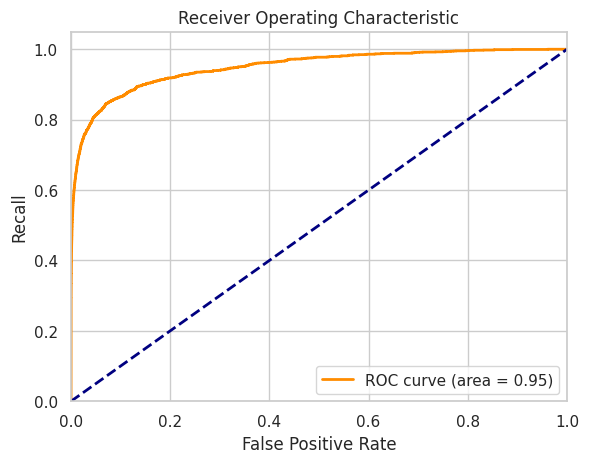

In [ ]:
y_pred = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

print("ROC AUC:", roc_auc)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
              linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

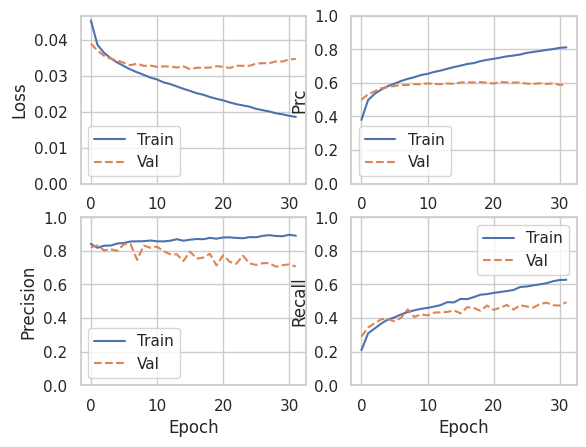

In [ ]:
plot_metrics(history)

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

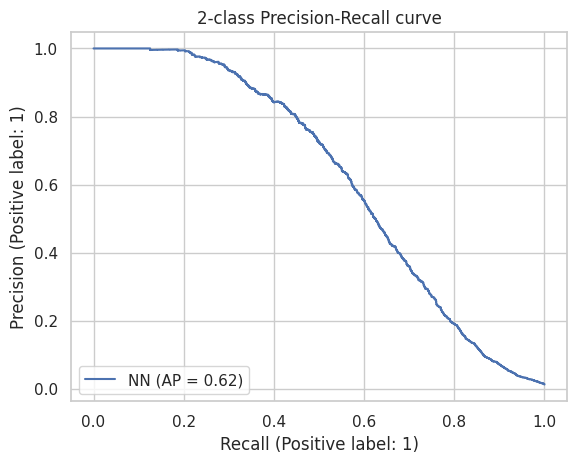

In [ ]:
display = PrecisionRecallDisplay.from_predictions(y_test, y_pred, name="NN")
_ = display.ax_.set_title("2-class Precision-Recall curve")

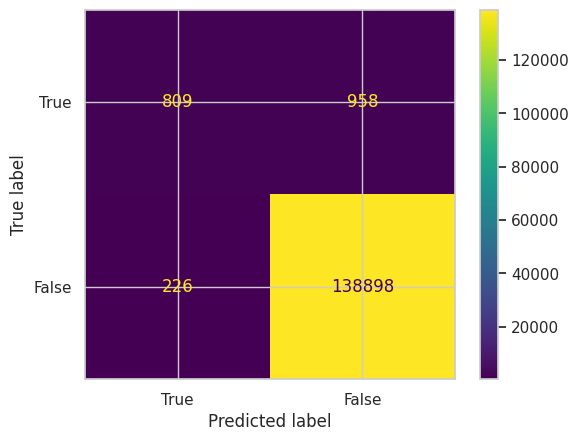

              precision    recall  f1-score   support

        True       0.78      0.46      0.58      1767
       False       0.99      1.00      1.00    139124

    accuracy                           0.99    140891
   macro avg       0.89      0.73      0.79    140891
weighted avg       0.99      0.99      0.99    140891



In [ ]:
#y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred>0.5, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred>0.5, labels=labels))